# **1. Introduction**
This notebook focuses on the empirical analysis of the Modern Phillips Curve using US macroeconomic data. The traditional Phillips Curve posits an inverse relationship between inflation and unemployment. The modern interpretation, often referred to as the New Keynesian Phillips Curve, incorporates factors like inflation expectations and supply shocks, suggesting that the relationship is more complex and can shift over time. This analysis aims to explore these relationships using relevant time series data.

## **1.1. The Modern Phillips Curve**

The Modern Phillips Curve, often termed the New Keynesian Phillips Curve (NKPC), represents an evolution of the original concept introduced by A.W. Phillips. Unlike the traditional view which posited a stable trade-off between inflation and unemployment, the modern interpretation acknowledges the significant role of **inflation expectations** and **supply shocks** in driving inflation dynamics.

Key features of the Modern Phillips Curve include:

*   **Forward-Looking Expectations:** A central tenet is that current inflation is influenced by expected future inflation. If individuals and firms anticipate higher inflation, they are likely to incorporate this into their wage and price setting decisions, leading to actual higher inflation. This highlights the importance of central bank credibility in anchoring expectations.

*   **Real Marginal Costs (Output Gap):** The relationship between inflation and economic activity is typically captured by the deviation of output from its potential level, known as the **output gap**, or by real marginal costs. A positive output gap (actual output above potential) suggests tight capacity and upward pressure on prices, while a negative output gap indicates slack in the economy and downward pressure. This relationship is often referred to as the "slope" of the Phillips Curve.

*   **Supply Shocks:** Events that directly affect production costs or the supply of goods and services (e.g., changes in oil prices, natural disasters) can shift the Phillips Curve, influencing inflation independently of the output gap or expectations.

*   **Lagged Inflation (Inertia):** While expectations are forward-looking, past inflation can also play a role due to wage and price-setting contracts, habit formation, or adaptive expectations. This introduces an element of inertia into the inflation process, leading to hybrid specifications that include both forward-looking and backward-looking components.

Econometric analysis of the Modern Phillips Curve often involves estimating equations that relate current inflation to measures of inflation expectations, the output gap (or unemployment gap), lagged inflation, and potentially indicators of supply shocks. The goal is to understand the relative importance of these factors and how the inflation process has evolved over time.

# **2. Import Required Libraries**

This section imports the necessary Python libraries for data handling, retrieval, visualization, and time series econometric analysis. Key libraries include `pandas` for data manipulation, `pandas_datareader` for fetching data from sources like FRED, `matplotlib` and `seaborn` for plotting, and `statsmodels` and `arch` for statistical and time series modeling.

In [1]:
# Install the ARCH package for unit root tests (e.g., Phillips-Perron) and GARCH modeling
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.5 MB/s eta 0:00:00


In [2]:
# Data Handling & Display
import pandas as pd
import numpy as np
from IPython.display import display
from datetime import datetime

# Data Retrieval
import pandas_datareader.data as pdr  # For accessing FRED and other online economic data

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Statistical and Time Series Analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick-Prescott filter
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from arch.unitroot import PhillipsPerron  # Phillips-Perron unit root test

# Model Diagnostics and Statistical Tests
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera, durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
import warnings
warnings.filterwarnings('ignore')

# **3. Data Collection and Pre-processing**

Data collection for this analysis involves retrieving specific macroeconomic time series from the Federal Reserve Economic Data (FRED) database. The chosen series are fundamental to examining the dynamics of the Modern Phillips Curve:

- **Consumer Price Index (CPI):** A key measure of inflation, reflecting the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services.
- **Gross Domestic Product (GDP):** The total monetary or market value of all the finished goods and services produced within a country's borders in a specific time period. Real GDP is used to adjust for inflation, providing a measure of economic output.
- **Inflation Expectations:** Survey-based or market-based indicators that capture the public's or financial market participants' beliefs about future inflation rates. Inflation expectations are a crucial element in the modern understanding of inflation dynamics.

Data preprocessing involves preparing these raw series for time series analysis. This typically includes steps like:
- **Variable Renaming:** Assigning clear and descriptive names to the imported data series.
- **Lag Creation:** Generating lagged versions of variables (e.g., lagged inflation) to capture past dynamics, which are often relevant in time series models.
- **Data Transformation:** Applying transformations like taking logarithms (e.g., log of Real GDP) to stabilize variance or linearize relationships, which can be necessary for certain modeling techniques.
- **Trend-Cycle Decomposition:** Using filters like the Hodrick-Prescott (HP) filter to separate a time series into a long-term trend component and a short-term cyclical component. The cyclical component of GDP is often used to represent the 'output gap', which is the difference between actual and potential output.
- **Handling Different Frequencies/Start Dates:** Resampling or merging series with different frequencies (e.g., monthly inflation expectations with quarterly GDP) or handling missing values that arise when combining series with different start dates. This ensures a consistent time index for the analysis.

## **3.1. Data Collection from FRED**
This section describes the process of collecting macroeconomic time series data from the Federal Reserve Economic Data (FRED) database. FRED is a valuable resource providing a wide range of economic indicators for the United States and other countries. For this analysis, specific series related to inflation, economic activity, and inflation expectations are retrieved using their unique FRED codes.

In [4]:
# Define start and end dates
start_date = '1960-01-01'
end_date = '2025-01-01'

# Fetch consumer price index (CPALTT01USQ657N), CPI index (CPIAUCSL) and expected inflation (EXPINF10YR) from FRED
cpi = pdr.get_data_fred('CPALTT01USQ657N', start=start_date, end=end_date)
gdp = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
exp_inf = pdr.get_data_fred('EXPINF10YR', start=start_date, end=end_date)

In [5]:
cpi.rename(columns={'CPALTT01USQ657N': 'Inflation Rate'}, inplace=True)

gdp.rename(columns={'GDPC1': 'Real GDP'}, inplace=True)

exp_inf.rename(columns={'EXPINF10YR': 'Inflation Expectation'}, inplace=True)

## **3.2. Data Preprocessing**
This section details the specific technical steps performed to preprocess the collected FRED data. This includes renaming columns for clarity, creating lagged variables, applying transformations like logarithms, and using filters such as the Hodrick-Prescott filter to derive relevant indicators like the output gap. Handling potential issues arising from different data frequencies or start dates during the merging process is also addressed to create a unified dataset for analysis.

In [6]:
# Convert exp_inf to quarterly data by resampling and taking the mean
exp_inf_quarterly = exp_inf.resample('QS').mean()

# Display the head and tail of the new quarterly data
print("Quarterly Inflation Expectation data:")
display(exp_inf_quarterly.head())
display(exp_inf_quarterly.tail())

Quarterly Inflation Expectation data:


,Inflation Expectation
DATE,
1982-01-01,5.974991
1982-04-01,5.668516
1982-07-01,5.781978
1982-10-01,4.973604
1983-01-01,4.729484


,Inflation Expectation
DATE,
2024-01-01,2.176487
2024-04-01,2.387175
2024-07-01,2.218920
2024-10-01,2.257641
2025-01-01,2.444260


In [7]:
# Lagged Inflation (π_{t-1})
cpi['Lagged Inflation'] = cpi['Inflation Rate'].shift(1)

# Display the head and tail
print("Quarterly Lagged İnflation:")
display(cpi.head())
display(cpi.tail())

Quarterly Lagged İnflation:


,Inflation Rate,Lagged Inflation
DATE,,
1960-01-01,-0.113379,NaN
1960-04-01,0.567537,-0.113379
1960-07-01,0.225734,0.567537
1960-10-01,0.675676,0.225734
1961-01-01,0.000000,0.675676


,Inflation Rate,Lagged Inflation
DATE,,
2023-01-01,1.044907,0.367161
2023-04-01,1.192332,1.044907
2023-07-01,0.866427,1.192332
2023-10-01,0.104508,0.866427
2024-01-01,1.042576,0.104508


In [8]:
# Log transformation is recommended because the time series shows a growth trend.
gdp["Log GDP"] = np.log(gdp["Real GDP"])

# HP Filter: separation of potential trend and cyclical components at the log level.
cycle, trend = sm.tsa.filters.hpfilter(gdp["Log GDP"], lamb=1600)  # λ = 1600 for quarterly data

# Output gap (%)
gdp["Output Gap (%)"] = (cycle / trend) * 100

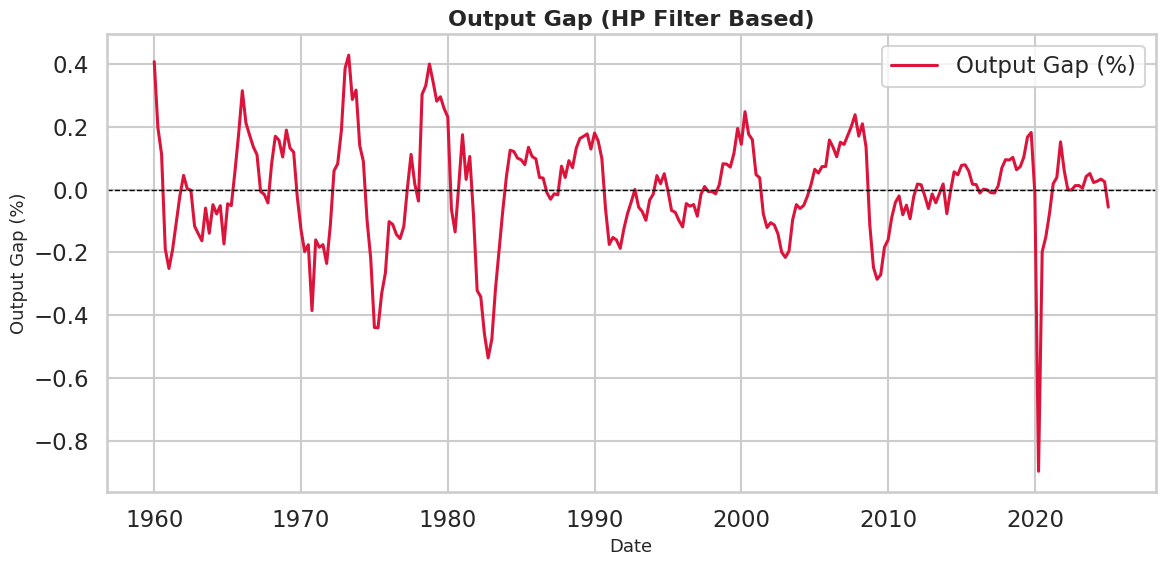

In [9]:
# Plot aesthetics
sns.set(style="whitegrid", context="talk", palette="muted")

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(gdp.index, gdp["Output Gap (%)"], color="crimson", linewidth=2.2, label="Output Gap (%)")
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Titles and labels
plt.title("Output Gap (HP Filter Based)", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=13)
plt.ylabel("Output Gap (%)", fontsize=13)
plt.legend(loc="upper right")
plt.tight_layout()

# Show the figure
plt.show()

In [10]:
# Merge CPI and Inflation Expectation Data first using a left join starting from 1960
data = pd.merge(cpi, exp_inf_quarterly, left_index=True, right_index=True, how='left')

# This will add GDP Data where available (from 1982) and leave NaNs before
data = pd.merge(data, gdp, left_index=True, right_index=True, how='left')

# Show the dataset - it should now start from 1960 and have NaNs for Inflation Expectation before 1982
print("Data merged starting from 1960, keeping all observations.")
display(data.head())
display(data.tail())

Data merged starting from 1960, keeping all observations.


,Inflation Rate,Lagged Inflation,Inflation Expectation,Real GDP,Log GDP,Output Gap (%)
DATE,,,,,,
1960-01-01,-0.113379,NaN,NaN,3517.181,8.165415,0.408121
1960-04-01,0.567537,-0.113379,NaN,3498.246,8.160017,0.197641
1960-07-01,0.225734,0.567537,NaN,3515.385,8.164904,0.113626
1960-10-01,0.675676,0.225734,NaN,3470.278,8.151990,-0.188741
1961-01-01,0.000000,0.675676,NaN,3493.703,8.158717,-0.251167


,Inflation Rate,Lagged Inflation,Inflation Expectation,Real GDP,Log GDP,Output Gap (%)
DATE,,,,,,
2023-01-01,1.044907,0.367161,2.216658,22403.435,10.016970,0.013260
2023-04-01,1.192332,1.044907,2.007067,22539.418,10.023021,0.004840
2023-07-01,0.866427,1.192332,2.141666,22780.933,10.033679,0.042206
2023-10-01,0.104508,0.866427,2.341729,22960.600,10.041535,0.051531
2024-01-01,1.042576,0.104508,2.176487,23053.545,10.045575,0.022848


# **4. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis (EDA) is a critical step in understanding the characteristics of a dataset before formal modeling. It involves using visualization and statistical methods to summarize the main features of the data. For time series analysis, EDA helps in identifying patterns, trends, seasonality, potential outliers, and the overall structure of the data.

Key aspects of EDA relevant to this analysis include:
- **Missing Values:** Assessing the presence and extent of missing data, which can impact subsequent analysis steps and require specific handling techniques.
- **Descriptive Statistics:** Calculating summary statistics such as mean, median, standard deviation, minimum, and maximum values to understand the central tendency, dispersion, and range of the variables.
- **Time Series Plots:** Visualizing the evolution of each variable over time to observe trends, cycles, volatility changes, and potential structural breaks.
- **Correlation Analysis:** Examining the linear relationships between pairs of variables using correlation coefficients and heatmaps to understand how variables move together.
- **Distribution Analysis:** Using histograms and density plots to visualize the frequency distribution of individual variables and assess their shape, symmetry, and kurtosis.
- **Bivariate Plots:** Creating scatter plots between key variables (like inflation and output gap) to visually inspect the relationship and identify any preliminary evidence supporting theoretical concepts like the Phillips Curve.

EDA findings provide crucial insights for selecting appropriate time series models, determining necessary transformations, and interpreting modeling results within the context of the data's properties.

## **4.1. Descriptive Statistics and Missing Values**

Understanding the basic statistical properties and completeness of the data is a foundational step in any quantitative analysis. This subsection focuses on examining descriptive statistics and identifying missing values within the dataset. Descriptive statistics provide a summary of the central tendency, dispersion, and shape of the data's distribution for each variable. Checking for missing values is essential for data cleaning and ensuring the reliability of subsequent calculations and model estimations, as many time series methods require complete data. The presence and pattern of missing data can also offer insights into the data collection process or underlying data availability issues.

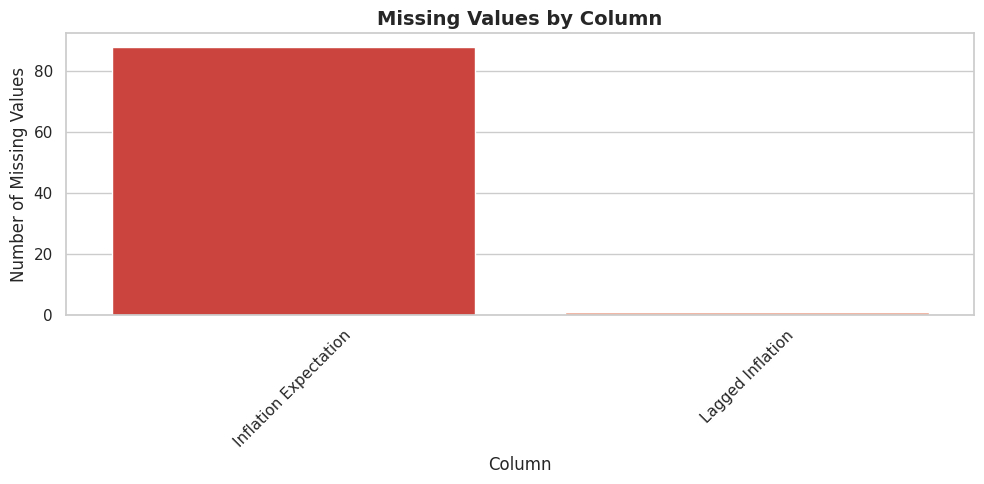

Column,Non-Null Count,Null Count,Dtype
Inflation Rate,257,0,float64
Lagged Inflation,256,1,float64
Inflation Expectation,169,88,float64
Real GDP,257,0,float64
Log GDP,257,0,float64
Output Gap (%),257,0,float64


,count,mean,std,min,25%,50%,75%,max,Missing (%)
Variable,,,,,,,,,
Inflation Rate,257.00,0.92,0.82,-2.83,0.40,0.82,1.22,3.95,0.00
Lagged Inflation,256.00,0.92,0.82,-2.83,0.40,0.81,1.22,3.95,0.39
Inflation Expectation,169.00,2.82,1.08,1.18,1.91,2.52,3.52,5.97,34.24
Real GDP,257.00,11479.29,5662.74,3470.28,6323.65,10236.43,16561.87,23053.54,0.00
Log GDP,257.00,9.21,0.54,8.15,8.75,9.23,9.71,10.05,0.00
Output Gap (%),257.00,-0.00,0.17,-0.90,-0.08,0.00,0.10,0.43,0.00


In [11]:
# Set visual style
sns.set(style="whitegrid")

# Check and visualize missing values
missing = data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing.index, y=missing.values, palette="Reds_r")
    plt.title("Missing Values by Column", fontsize=14, fontweight='bold')
    plt.ylabel("Number of Missing Values")
    plt.xlabel("Column")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected in the dataset.")

# Display non-null, null, and dtype information
def dataframe_info_table(df):
    info_data = {
        "Column": df.columns,
        "Non-Null Count": df.notnull().sum().values,
        "Null Count": df.isnull().sum().values,
        "Dtype": df.dtypes.values
    }
    return pd.DataFrame(info_data)

info_data = dataframe_info_table(data)
styled_info = info_data.style.set_caption("DataFrame Information Summary") \
                           .format({'Non-Null Count': "{:,}", 'Null Count': "{:,}"}) \
                           .background_gradient(subset=['Null Count'], cmap='Reds') \
                           .hide(axis="index")

display(styled_info)

# Descriptive statistics with variable names and styled output
desc_data = data.describe().T  
desc_data.index.name = "Variable" 
desc_data["Missing (%)"] = data.isnull().mean() * 100

styled_desc = desc_data.style.set_caption("Descriptive Statistics Summary") \
                           .format("{:.2f}") \
                           .background_gradient(cmap='Blues', subset=['mean', 'std']) \
                           .bar(subset=['Missing (%)'], color='salmon')
                          
display(styled_desc)

## **4.2. Correlation Analysis**

Correlation analysis is used to measure the degree of linear association between two or more variables. A correlation matrix displays the pairwise correlation coefficients for a set of variables. The values range from -1 to +1, where +1 indicates a perfect positive linear correlation, -1 indicates a perfect negative linear correlation, and 0 indicates no linear correlation. Visualizing the correlation matrix using a heatmap provides a clear overview of the relationships between all pairs of variables simultaneously, with color intensity often representing the strength of the correlation. This helps in identifying potential multicollinearity issues among predictor variables in regression analysis and understanding which variables tend to move together.

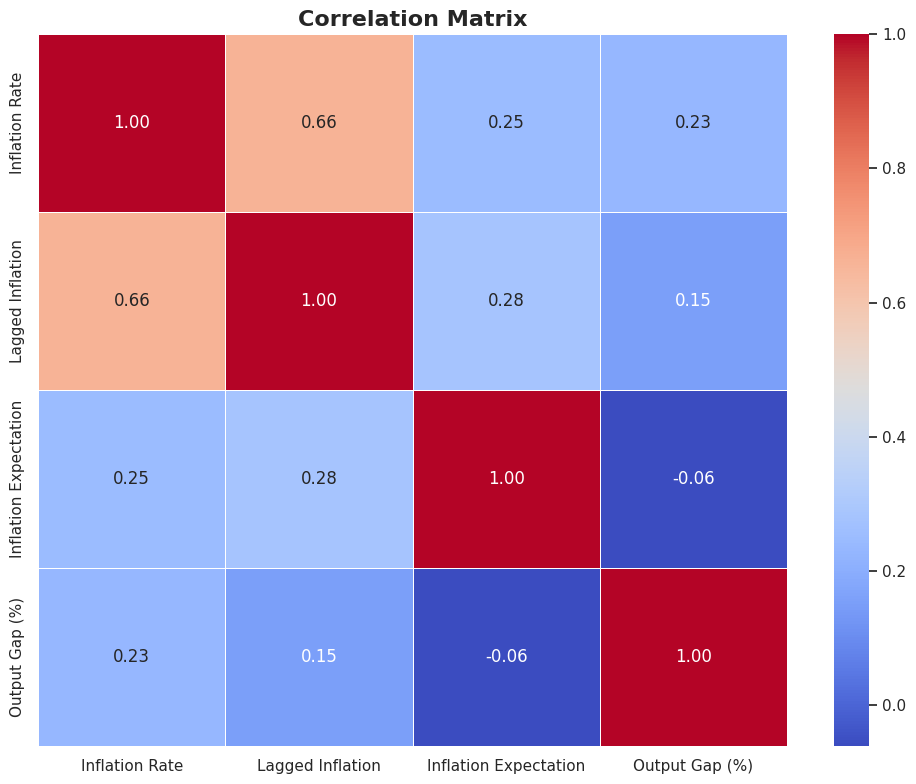

In [12]:
# Calculate the correlation matrix
corr_matrix = data[['Inflation Rate', 'Lagged Inflation', 'Inflation Expectation', 'Output Gap (%)']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## **4.3. Distribution Analysis (Histograms)**

Analyzing the distribution of individual variables is important for understanding their characteristics and for selecting appropriate statistical methods. Histograms are graphical representations that show the frequency distribution of a numerical variable by dividing the data into bins and displaying the count or proportion of observations falling into each bin. The shape of a histogram can reveal whether the distribution is symmetric or skewed, unimodal or multimodal, and whether there are potential outliers. Including a Kernel Density Estimate (KDE) overlay provides a smoothed representation of the data's probability density function, which can help in visualizing the underlying distribution shape more clearly.

Histogram Distributions of Key Variables


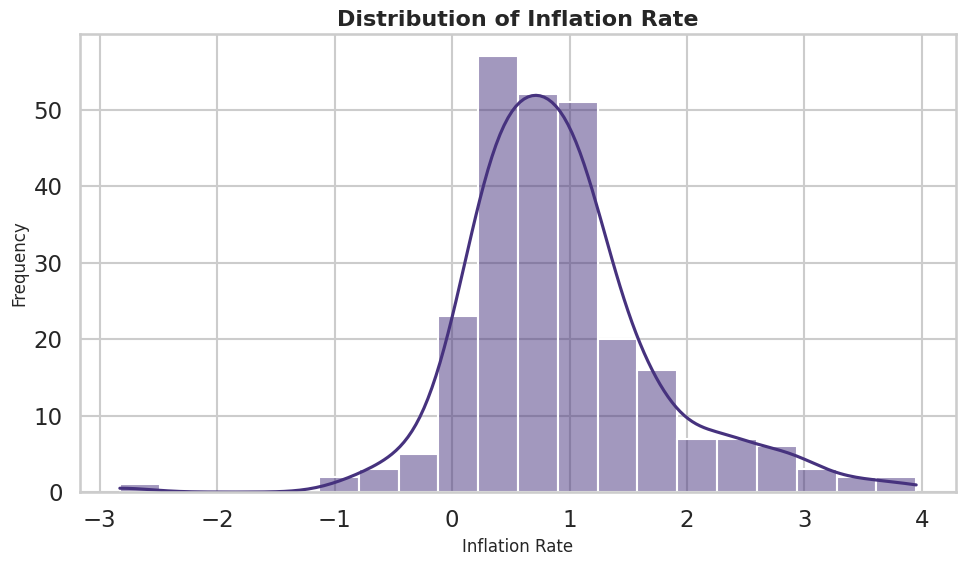

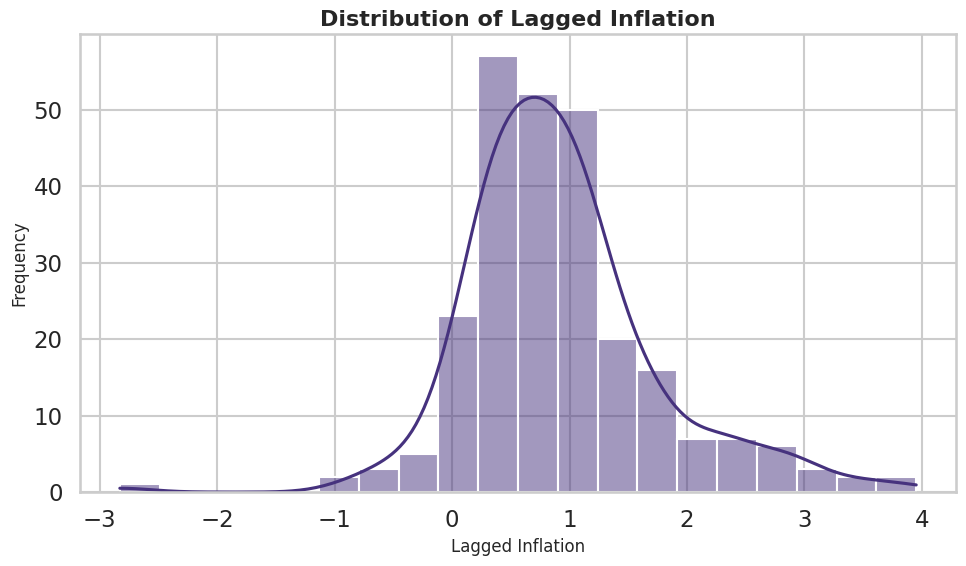

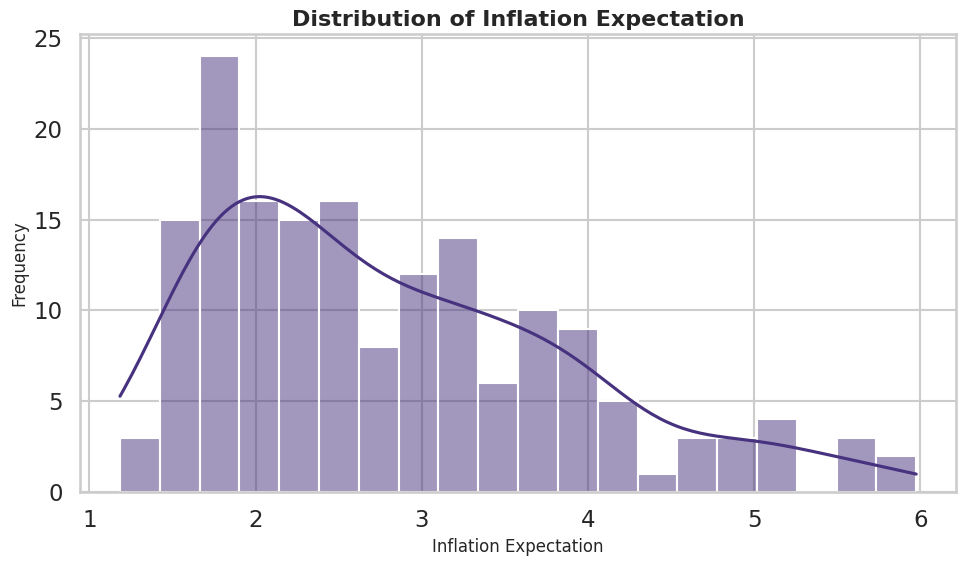

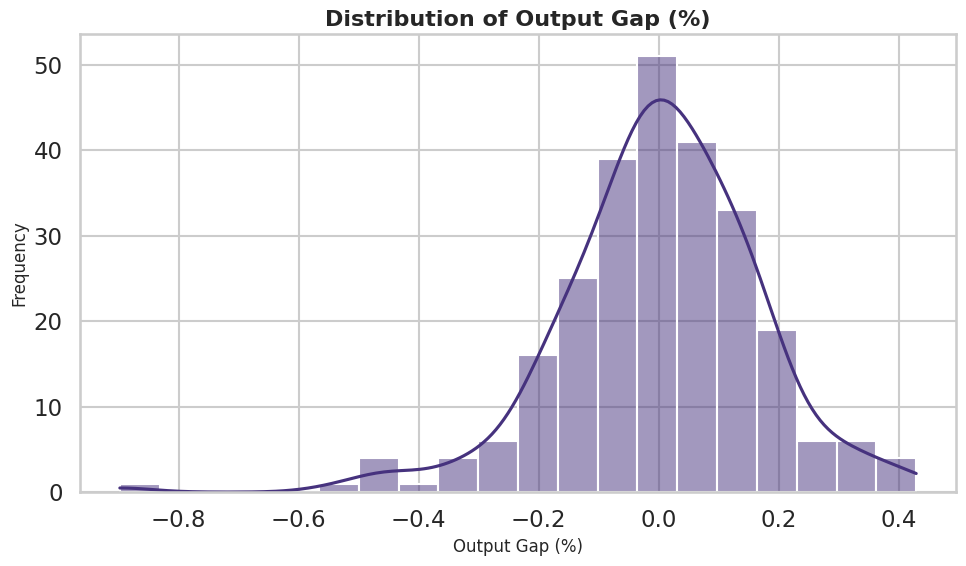

In [13]:
# Set a professional and aesthetic style
sns.set(style="whitegrid", context="talk", palette="viridis")

# List of variables to plot histograms for
variables_to_plot = ['Inflation Rate', 'Lagged Inflation', 'Inflation Expectation', 'Output Gap (%)']

print("Histogram Distributions of Key Variables")

# Loop through each variable and create a histogram
for var in variables_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=var, kde=True, bins=20, color=sns.color_palette("viridis")[0]) # Add KDE for density curve
    plt.title(f'Distribution of {var}', fontsize=16, fontweight='bold')
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

## **4.4. Phillips Curve Relationship (Regression Plot)**

This plot aims to visually explore the bivariate relationship between the inflation rate and the output gap, a core concept in the Phillips Curve framework. A scatter plot is used to show the individual data points representing pairs of observations for these two variables at different points in time. A regression line is typically fitted to this scatter plot to illustrate the average linear relationship between the variables. This visualization provides a preliminary, non-causal look at how changes in the output gap are associated with changes in the inflation rate, offering an initial graphical intuition about the Phillips Curve.

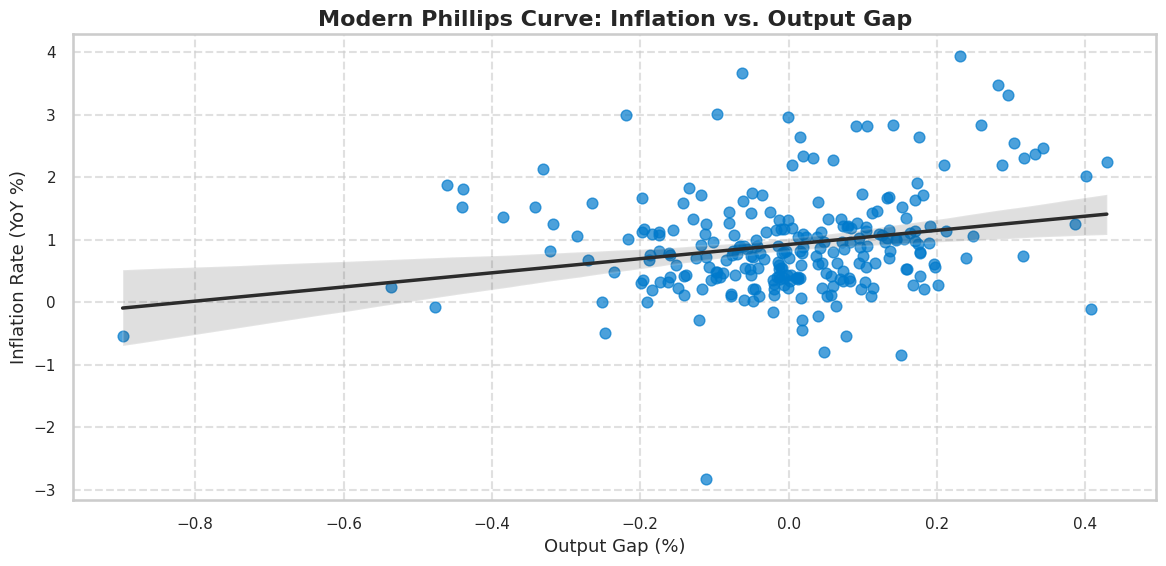

In [14]:
# Set visual aesthetics for publication-quality output
sns.set(style="whitegrid", context="talk", palette="muted")

# Initialize figure
plt.figure(figsize=(12, 6), dpi=100)

# Create the regression plot
sns.regplot(
    data=data,
    x='Output Gap (%)',
    y='Inflation Rate',
    scatter_kws={
        's': 60,            
        'alpha': 0.7,        
        'color': '#007acc'   
    },
    line_kws={
        'color': '#2c2c2c', 
        'linewidth': 2.5
    },
    ci=95  # 95% Confidence Interval
)

# Title and axis labels
plt.title("Modern Phillips Curve: Inflation vs. Output Gap", fontsize=16, fontweight='bold')
plt.xlabel("Output Gap (%)", fontsize=13)
plt.ylabel("Inflation Rate (YoY %)", fontsize=13)

# Axis formatting
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()

# **5. Time Series Analysis**

This section delves into formal time series analysis techniques to model the dynamics of the variables and estimate the Modern Phillips Curve. Time series data have unique characteristics, such as temporal dependence (autocorrelation) and potential non-stationarity, which require specialized methods. This section covers steps like examining autocorrelation and partial autocorrelation functions, conducting unit root tests to assess stationarity, exploring cointegration relationships between non-stationary series, estimating econometric models like the Error Correction Model (ECM) to capture both short-run and long-run dynamics, performing diagnostic tests to evaluate model assumptions, and assessing model performance. Understanding these concepts is crucial for drawing valid inferences from time series data.

## **5.1. Timeline of Macroeconomic and Political Shocks**

Macroeconomic time series are significantly influenced by historical events, including major economic crises, policy shifts, and geopolitical developments. Creating a timeline of significant events provides essential context for interpreting the observed patterns and fluctuations in the data. Such events can act as structural breaks or sudden shocks that alter the behavior of economic variables. Visualizing these events alongside the time series data helps in understanding potential causal links and historical periods of instability or significant change. This contextualization is vital for a robust time series analysis, allowing researchers to consider how external factors may have impacted the relationships between variables.

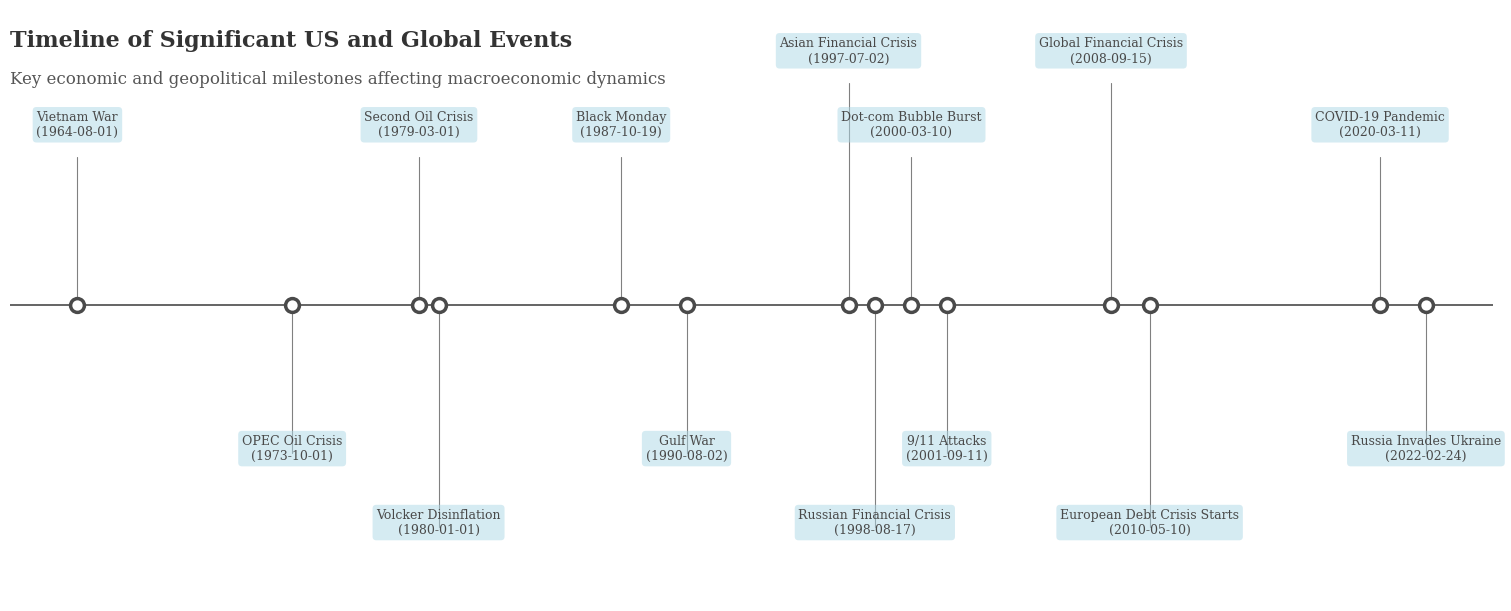

In [15]:
# Define major US/global economic and political events
events = {
    'Vietnam War': '1964-08-01',
    'OPEC Oil Crisis': '1973-10-01',
    'Second Oil Crisis': '1979-03-01',
    'Volcker Disinflation': '1980-01-01',
    'Black Monday': '1987-10-19',
    'Gulf War': '1990-08-02',
    'Asian Financial Crisis': '1997-07-02',
    'Russian Financial Crisis': '1998-08-17',
    'Dot-com Bubble Burst': '2000-03-10',
    '9/11 Attacks': '2001-09-11',
    'Global Financial Crisis': '2008-09-15',
    'European Debt Crisis Starts': '2010-05-10',
    'COVID-19 Pandemic': '2020-03-11',
    'Russia Invades Ukraine': '2022-02-24'
}

# Convert dates
event_dates = {name: pd.to_datetime(date) for name, date in events.items()}
sorted_events = sorted(event_dates.items(), key=lambda x: x[1])
event_names = [e[0] for e in sorted_events]
event_dates_list = [e[1] for e in sorted_events]

# Create figure
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# Draw timeline
ax.axhline(0, color='#4a4a4a', linewidth=1.2, zorder=1)

# Plot points
ax.scatter(event_dates_list, np.zeros(len(event_dates_list)), s=120, color='#4a4a4a', zorder=2)
ax.scatter(event_dates_list, np.zeros(len(event_dates_list)), s=35, color='white', zorder=3)

# Position cycling
y_levels = [0.4, -0.4, 0.6, -0.6]
text_offset = 0.05

# Annotate
for i, (event, date) in enumerate(sorted_events):
    # Default vertical level
    y = y_levels[i % len(y_levels)]

    # Special fix: place "Second Oil Crisis" above the line
    if event == 'Second Oil Crisis':
        y = 0.4  

    # Text label
    ax.text(date, y + text_offset,
            f'{event}\n({date.strftime("%Y-%m-%d")})',
            ha='center',
            va='bottom' if y > 0 else 'top',
            fontsize=9,
            fontfamily='serif',
            color='#4a4a4a',
            bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', ec='none', alpha=0.5))

    # Connecting line
    ax.plot([date, date], [0, y], color='gray', linestyle='-', linewidth=0.8, zorder=0)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')

# Remove y-axis and spines
ax.set_ylim(-0.8, 0.8)
ax.yaxis.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
for spine in ["top", "left", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

# Title and subtitle
plot_start = ax.get_xlim()[0]
ax.text(plot_start, 0.7, 'Timeline of Significant US and Global Events',
        fontsize=16, fontweight='bold', ha='left', fontfamily='serif', color='#333333')
ax.text(plot_start, 0.6, 'Key economic and geopolitical milestones affecting macroeconomic dynamics',
        fontsize=12, ha='left', fontfamily='serif', color='#555555')

plt.show()

## **5.2. The Visual Impact of Periodic Shocks on Macroeconomic Indicators**

Examining macroeconomic time series in conjunction with significant historical events allows for a qualitative assessment of the potential impact of these events on the variables. By plotting key economic indicators and marking the dates of major economic and political shocks, one can visually inspect whether these events coincide with noticeable shifts, spikes, or changes in the trend or volatility of the series. This visual exploration can help in identifying periods where structural breaks might have occurred or where external factors exerted significant influence. Grouping events and focusing on specific historical periods can further highlight how different economic environments or types of shocks may have affected the dynamics of inflation, output, and expectations.

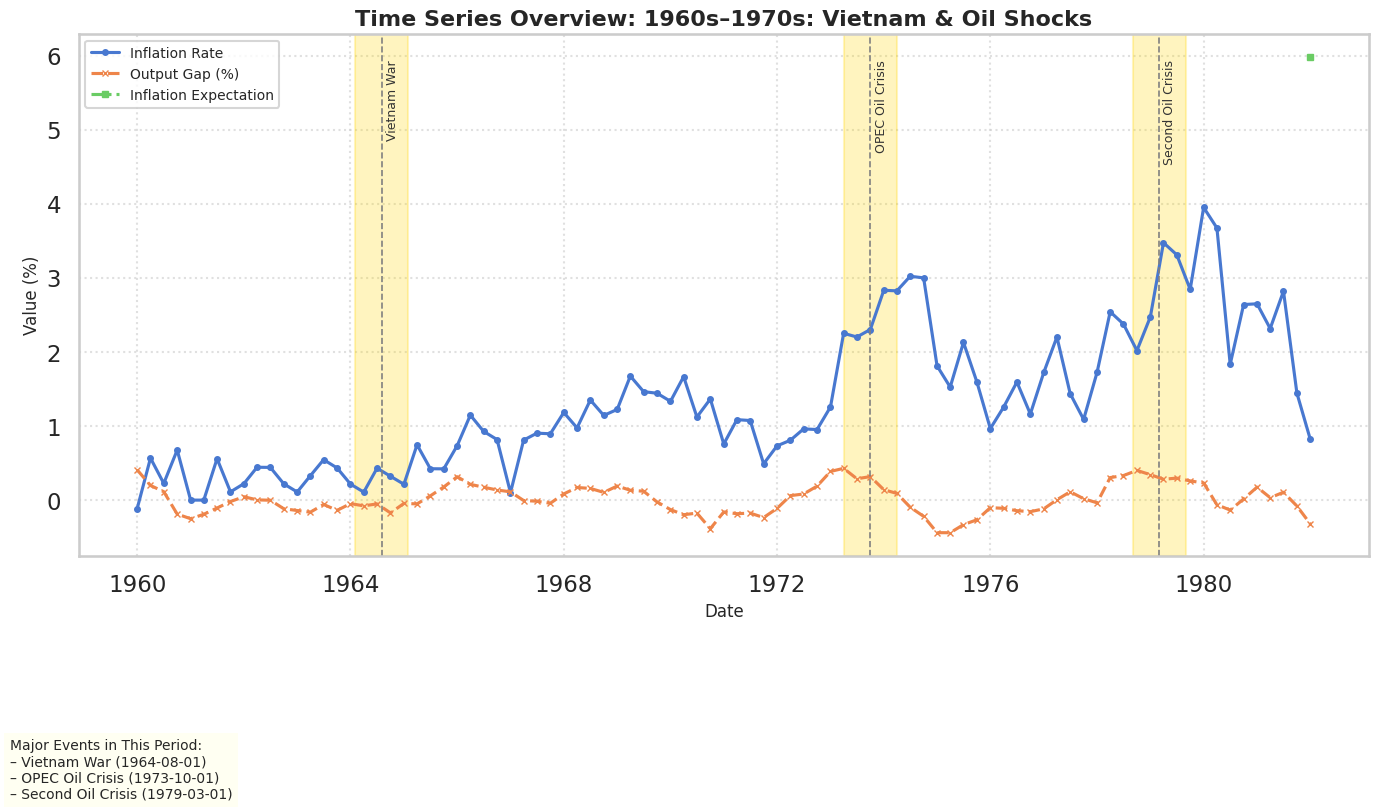

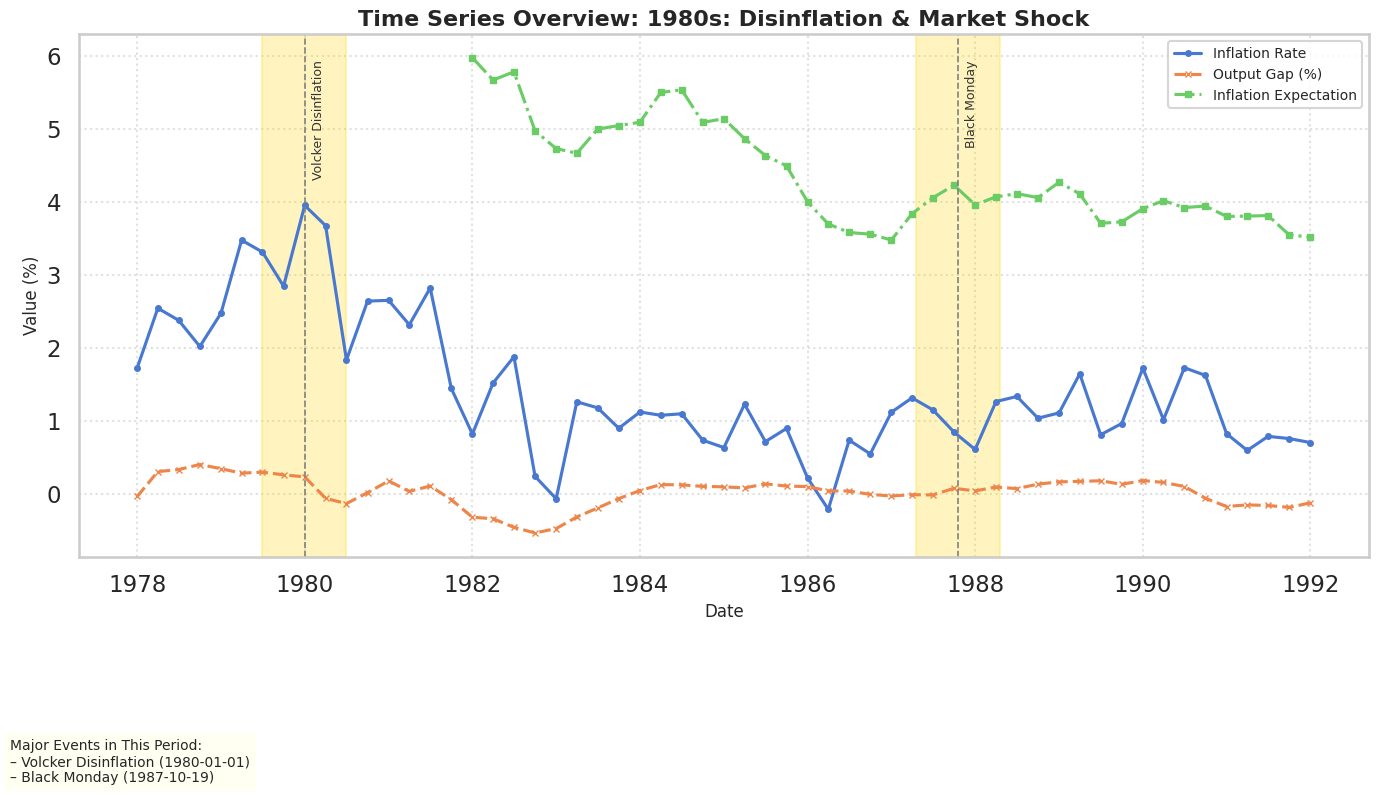

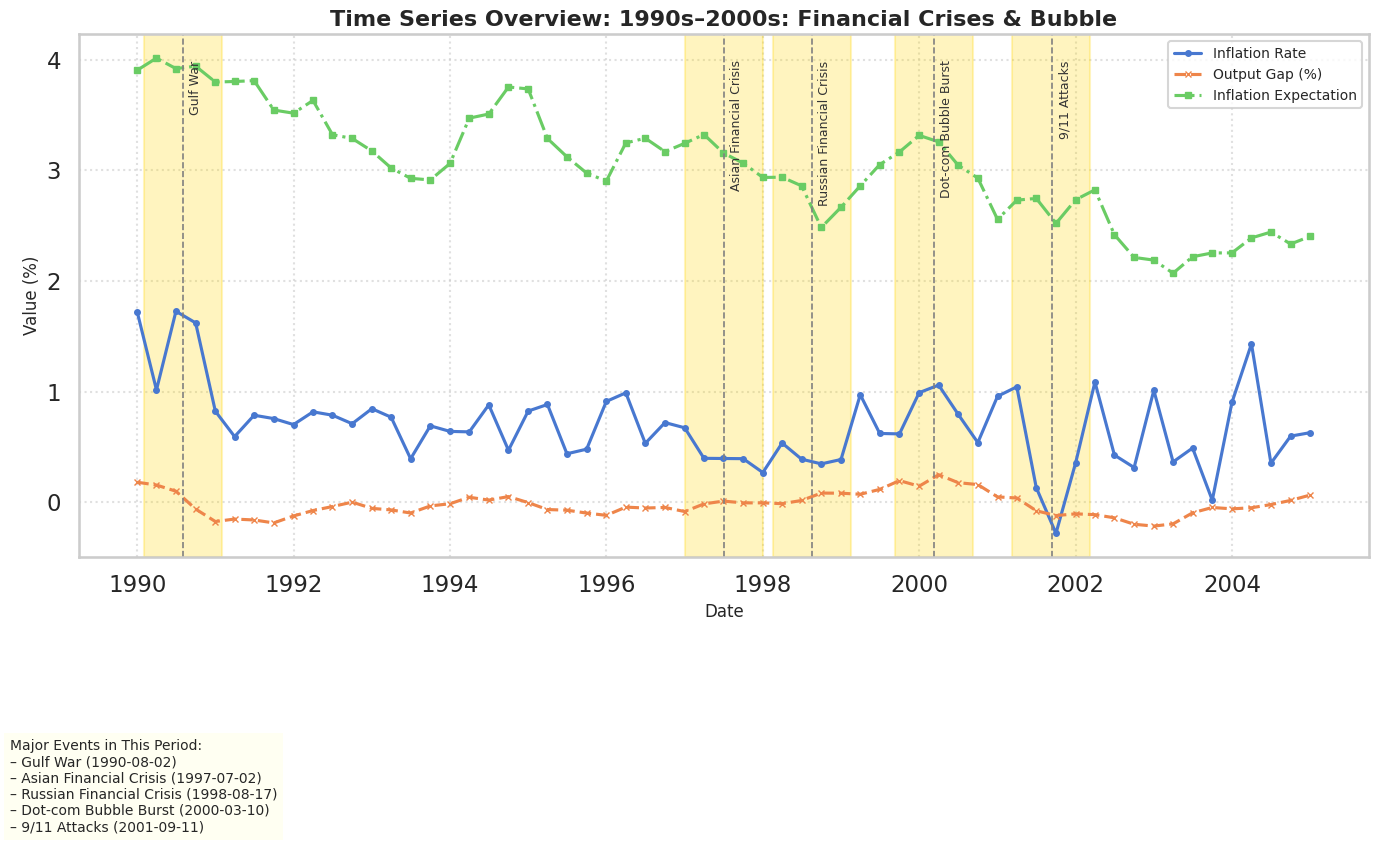

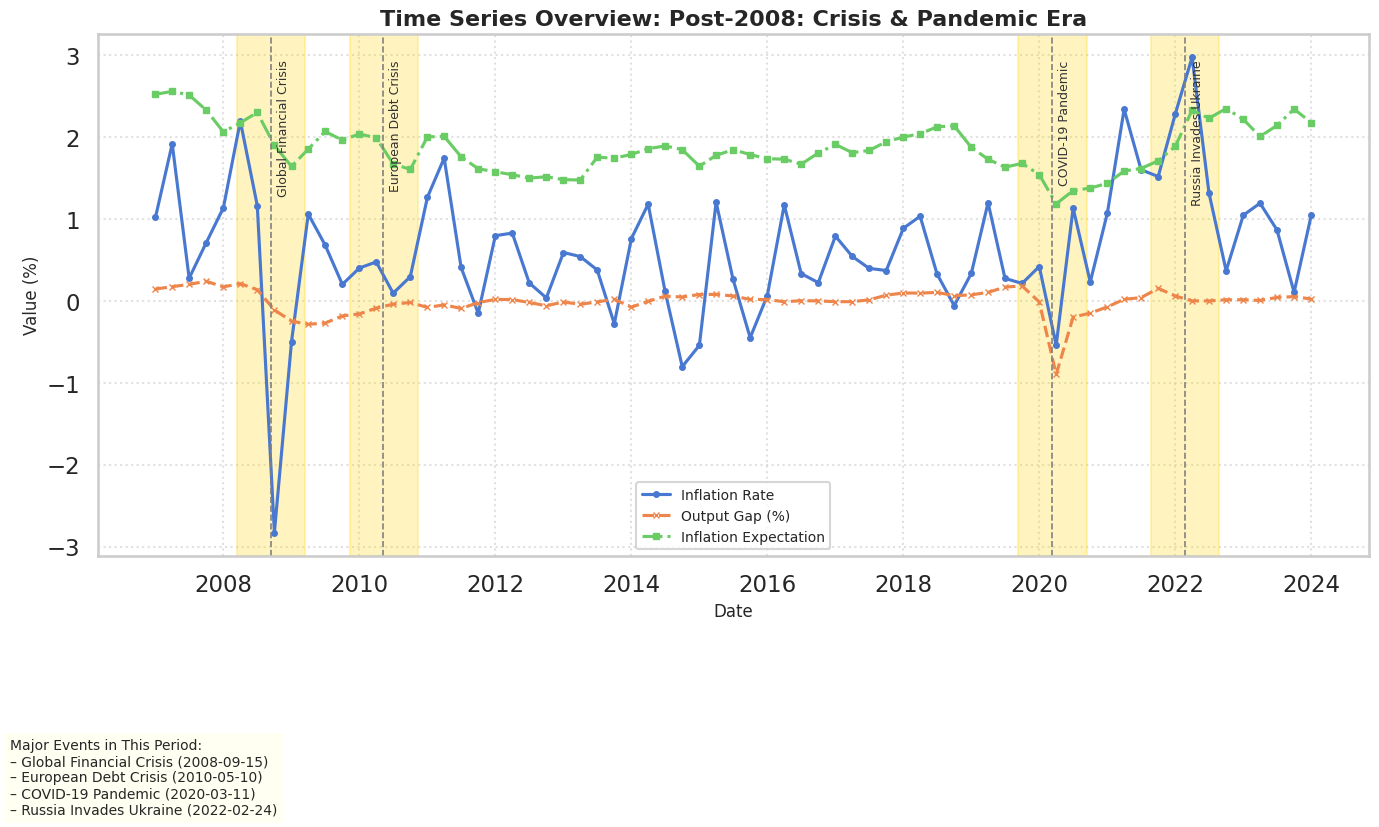

In [16]:
# Ensure the index is a datetime type
data.index = pd.to_datetime(data.index)

# Define significant events and their approximate dates
events = {
    'Vietnam War': '1964-08-01',
    'OPEC Oil Crisis': '1973-10-01',
    'Second Oil Crisis': '1979-03-01',
    'Volcker Disinflation': '1980-01-01',
    'Black Monday': '1987-10-19',
    'Gulf War': '1990-08-02',
    'Asian Financial Crisis': '1997-07-02',
    'Russian Financial Crisis': '1998-08-17',
    'Dot-com Bubble Burst': '2000-03-10',
    '9/11 Attacks': '2001-09-11',
    'Global Financial Crisis': '2008-09-15',
    'European Debt Crisis': '2010-05-10',
    'COVID-19 Pandemic': '2020-03-11',
    'Russia Invades Ukraine': '2022-02-24'
}
event_dates = {name: pd.to_datetime(date) for name, date in events.items()}

# Group events into historical-economic periods
event_groups = {
    '1960s–1970s: Vietnam & Oil Shocks': ['Vietnam War', 'OPEC Oil Crisis', 'Second Oil Crisis'],
    '1980s: Disinflation & Market Shock': ['Volcker Disinflation', 'Black Monday'],
    '1990s–2000s: Financial Crises & Bubble': ['Gulf War', 'Asian Financial Crisis', 'Russian Financial Crisis',
                                               'Dot-com Bubble Burst', '9/11 Attacks'],
    'Post-2008: Crisis & Pandemic Era': ['Global Financial Crisis', 'European Debt Crisis',
                                         'COVID-19 Pandemic', 'Russia Invades Ukraine']
}

# Define plotting windows for each group
plotting_windows = {
    '1960s–1970s: Vietnam & Oil Shocks': ('1960-01-01', '1982-01-01'),
    '1980s: Disinflation & Market Shock': ('1978-01-01', '1992-01-01'),
    '1990s–2000s: Financial Crises & Bubble': ('1990-01-01', '2005-01-01'),
    'Post-2008: Crisis & Pandemic Era': ('2007-01-01', '2025-01-01')
}

# Iterate over periods and generate annotated plots
for group_name, (start, end) in plotting_windows.items():
    fig, ax = plt.subplots(figsize=(14, 7))

    # Filter data by time window
    data_period = data.loc[start:end]

    # Plot time series
    ax.plot(data_period.index, data_period['Inflation Rate'], label='Inflation Rate', marker='o', linestyle='-', markersize=4)
    ax.plot(data_period.index, data_period['Output Gap (%)'], label='Output Gap (%)', marker='x', linestyle='--', markersize=4)
    ax.plot(data_period.index, data_period['Inflation Expectation'], label='Inflation Expectation', marker='s', linestyle='-.', markersize=4)

    # Event annotations and highlights
    y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
    event_notes = []

    for event in event_groups[group_name]:
        date = event_dates[event]
        if start <= str(date) <= end:
            # Vertical line
            ax.axvline(date, color='gray', linestyle='--', linewidth=1.2)

            # Shaded area (+/- 6 months)
            shade_start = max(date - pd.DateOffset(months=6), pd.to_datetime(start))
            shade_end = min(date + pd.DateOffset(months=6), pd.to_datetime(end))
            ax.axvspan(shade_start, shade_end, color='gold', alpha=0.25)

            # Annotation label
            ax.text(date + pd.DateOffset(days=30),
                    ax.get_ylim()[1] - y_offset,
                    event,
                    rotation=90,
                    fontsize=9,
                    color='#333333',
                    ha='left',
                    va='top')

            event_notes.append(f"– {event} ({date.strftime('%Y-%m-%d')})")

    # Title, labels, legend
    ax.set_title(f'Time Series Overview: {group_name}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Value (%)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.6)

    # Text box for listed events
    if event_notes:
        note_text = "Major Events in This Period:\n" + "\n".join(event_notes)
        fig.text(0.01, -0.08, note_text, ha='left', va='top', fontsize=10,
                 bbox=dict(facecolor='lightyellow', alpha=0.4, edgecolor='none'))

    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


## **5.3. New Data Preprocessing for Creating An Econometric Model**

Before proceeding with time series modeling, it is necessary to handle missing values in the dataset. As observed in the EDA section, the `Inflation Expectation` variable is not available prior to 1982, and the `Lagged Inflation` variable has a missing value for the very first observation.

To ensure a complete dataset for model estimation, a new DataFrame `df` is created by copying the original `data` DataFrame. Rows containing any missing values are then removed using the `dropna()` method. This operation effectively subsets the data to the period starting from 1982, where all key variables (`Inflation Rate`, `Lagged Inflation`, `Inflation Expectation`, and `Output Gap (%)`) have available observations. The analysis and modeling steps that follow will therefore be based on this cleaned `df` DataFrame.

In [17]:
# Create a new dataframe 'df' by copying 'data'
df = data.copy()

# Drop rows with any missing values (this will effectively start the df from 1982)
df.dropna(inplace=True)

# Display the head and tail of the new df to show the result
display(df.head())
display(df.tail())

,Inflation Rate,Lagged Inflation,Inflation Expectation,Real GDP,Log GDP,Output Gap (%)
DATE,,,,,,
1982-01-01,0.818214,1.443522,5.974991,7295.631,8.895031,-0.321866
1982-04-01,1.517290,0.818214,5.668516,7328.912,8.899582,-0.341519
1982-07-01,1.876955,1.517290,5.781978,7300.896,8.895752,-0.459995
1982-10-01,0.238826,1.876955,4.973604,7303.817,8.896152,-0.536518
1983-01-01,-0.068074,0.238826,4.729484,7400.066,8.909244,-0.476837


,Inflation Rate,Lagged Inflation,Inflation Expectation,Real GDP,Log GDP,Output Gap (%)
DATE,,,,,,
2023-01-01,1.044907,0.367161,2.216658,22403.435,10.016970,0.013260
2023-04-01,1.192332,1.044907,2.007067,22539.418,10.023021,0.004840
2023-07-01,0.866427,1.192332,2.141666,22780.933,10.033679,0.042206
2023-10-01,0.104508,0.866427,2.341729,22960.600,10.041535,0.051531
2024-01-01,1.042576,0.104508,2.176487,23053.545,10.045575,0.022848


## **5.4. Visual Timeline of Key Macroeconomic Indicators and Historical Shock (New Dataset)**

This graph is the time series of the key macroeconomic indicators used in the analysis – Inflation Rate, Inflation Expectation, Lagged Inflation, and Output Gap (%) – specifically focusing on the period from 1982 onwards, after dropping rows with missing values.

The plot includes annotations and shaded regions to highlight the approximate dates and periods surrounding significant economic and political events that occurred during this timeframe. This allows for a visual examination of how these events might correspond with changes or shifts in the behavior of the time series variables.

The purpose is to provide a visual context for the subsequent time series analysis by illustrating the trends, volatility, and potential impacts of major historical shocks on the variables of interest.

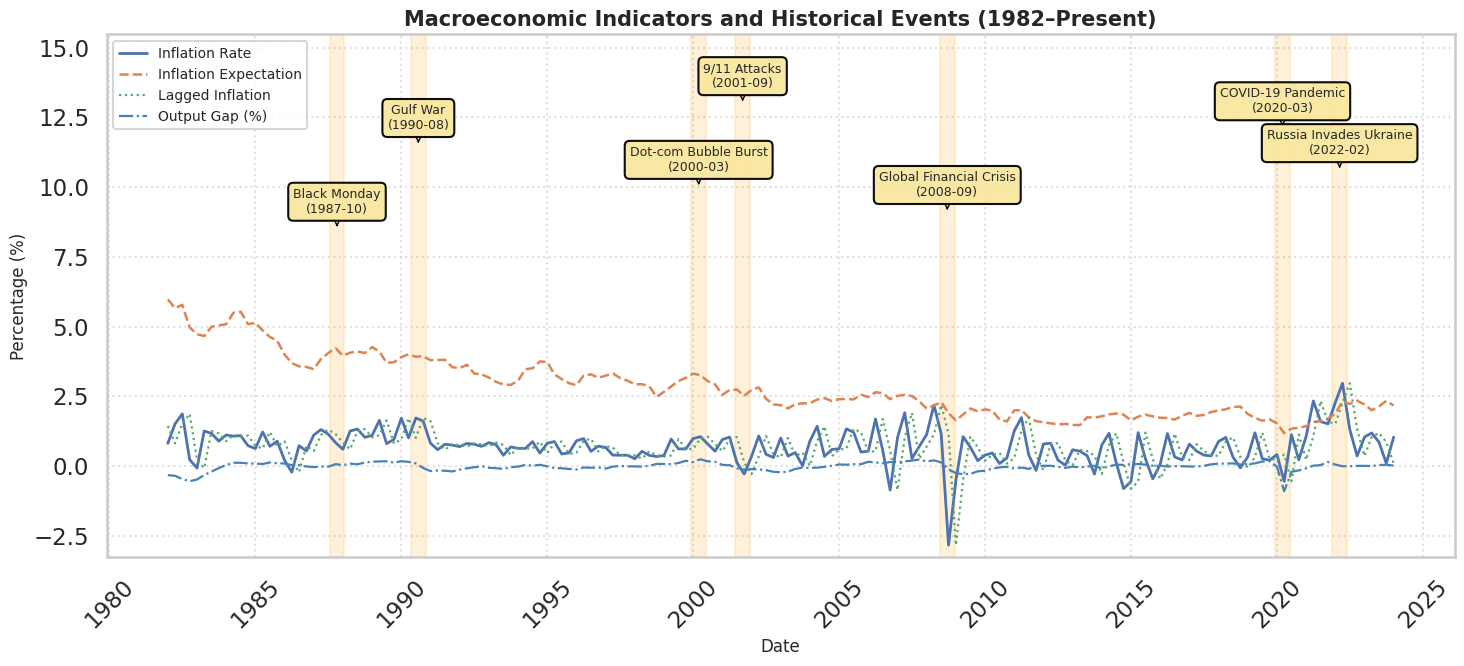

In [18]:
# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Plot style
sns.set(style="whitegrid", context="talk")

# Figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Plot indicators
ax.plot(df.index, df['Inflation Rate'], label='Inflation Rate', linewidth=2)
ax.plot(df.index, df['Inflation Expectation'], label='Inflation Expectation', linestyle='--', linewidth=1.8)
ax.plot(df.index, df['Lagged Inflation'], label='Lagged Inflation', linestyle=':', linewidth=1.6)
ax.plot(df.index, df['Output Gap (%)'], label='Output Gap (%)', linestyle='-.', linewidth=1.6, color='steelblue')

# Define major events and their dates
events = {
    'Black Monday': '1987-10-19',
    'Gulf War': '1990-08-02',
    'Dot-com Bubble Burst': '2000-03-10',
    '9/11 Attacks': '2001-09-11',
    'Global Financial Crisis': '2008-09-15',
    'COVID-19 Pandemic': '2020-03-11',
    'Russia Invades Ukraine': '2022-02-24'
}

# Get max Y value for annotation spacing
y_max = df[['Inflation Rate', 'Inflation Expectation']].max().max()
spacing = 3
arrow_levels = [y_max + spacing * i for i in [1, 2, 1.5, 2.5, 1.2, 2.2, 1.7]]

# Plot shaded bands and annotation arrows
for i, (name, date_str) in enumerate(events.items()):
    date = pd.to_datetime(date_str)
    if date < df.index.min() or date > df.index.max():
        continue

    # Shade ±3 months around each event
    ax.axvspan(date - pd.DateOffset(months=3), date + pd.DateOffset(months=3), color='orange', alpha=0.15)

    # Annotate with arrow and box
    y_text = arrow_levels[i % len(arrow_levels)]
    y_arrow = y_text - 0.5

    ax.annotate(f"{name}\n({date.strftime('%Y-%m')})",
                xy=(date, y_arrow),
                xytext=(date, y_text),
                textcoords="data",
                ha='center', va='bottom',
                fontsize=9,
                arrowprops=dict(arrowstyle="->", color='black', lw=1),
                bbox=dict(boxstyle="round,pad=0.4", fc='#f9e79f', ec='black', alpha=0.95))

# Add title and labels
ax.set_title("Macroeconomic Indicators and Historical Events (1982–Present)",
             fontsize=15, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)

# Format x-axis with 5-year intervals
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add legend and grid
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, linestyle=':', alpha=0.6)

# Adjust y-axis limit to fit annotations
ax.set_ylim(top=max(arrow_levels) + 2)

plt.tight_layout()
plt.show()


## **5.5. Univariate Time Series Plot: Inflation Rate**

This code block generates a time series plot specifically for the 'Inflation Rate' variable from the cleaned dataset (df). The plot shows the evolution of the quarterly inflation rate over time. Visualizing the inflation rate on its own allows for a clear view of its trend, volatility, and any apparent cycles or significant changes over the period covered by the data (starting from 1982 after handling missing values). This focused visualization is helpful for observing the historical behavior of inflation in isolation before analyzing its relationship with other variables.

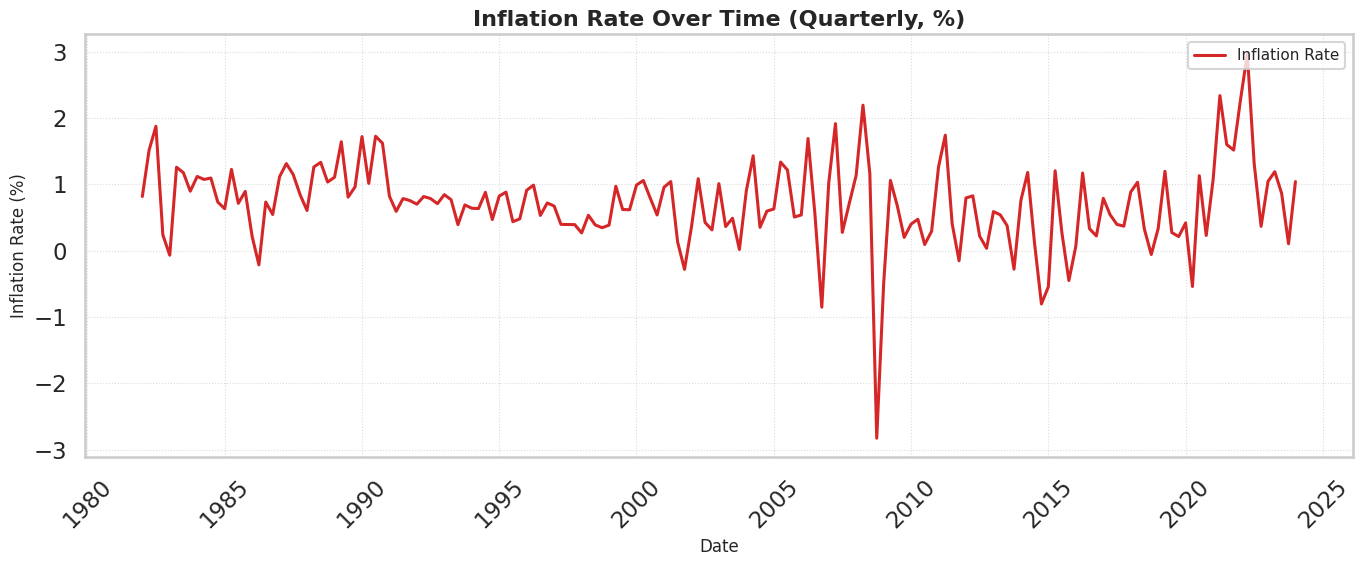

In [19]:
# Set Seaborn plot style
sns.set(style='whitegrid', context="talk")

# Define figure size
plt.figure(figsize=(14, 6))

# Plot the Inflation Rate time series
plt.plot(df.index, df["Inflation Rate"], color="#d62728", linewidth=2.2, label="Inflation Rate")

# Add title and axis labels
plt.title("Inflation Rate Over Time (Quarterly, %)", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)

# Customize ticks and grid
plt.xticks(rotation=45)
plt.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)

# Show legend
plt.legend(loc="upper right", fontsize=11)

# Optimize layout
plt.tight_layout()
plt.show()

## **5.6. ACP And PACF**

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are fundamental tools in time series analysis for understanding the dependence structure of a series.

- **Autocorrelation Function (ACF):** Measures the correlation between a time series and its lagged values at different time lags. It shows how the correlation decays as the lag increases. For a stationary time series, the ACF typically decays rapidly. For a non-stationary series, particularly one with a unit root, the ACF tends to decay slowly.

- **Partial Autocorrelation Function (PACF):** Measures the correlation between a time series and its lagged values after removing the linear dependence from the intermediate lags. It helps in identifying the order of an Autoregressive (AR) model.

Examining the ACF and PACF plots for both the original series and their first differences is a common practice to visually assess stationarity and determine potential model orders for AR, MA, ARMA, or ARIMA models. A series is considered stationary if its statistical properties (mean, variance, autocorrelation) do not change over time.

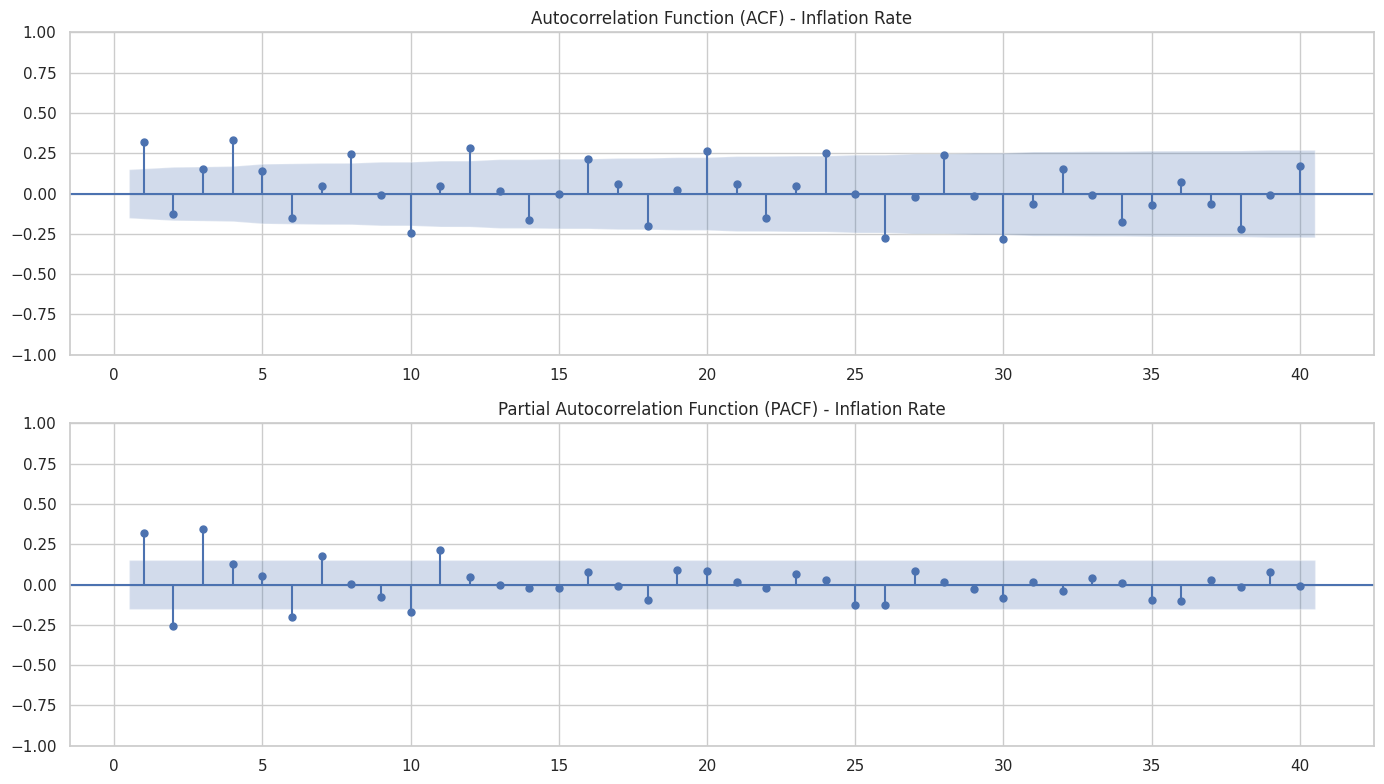

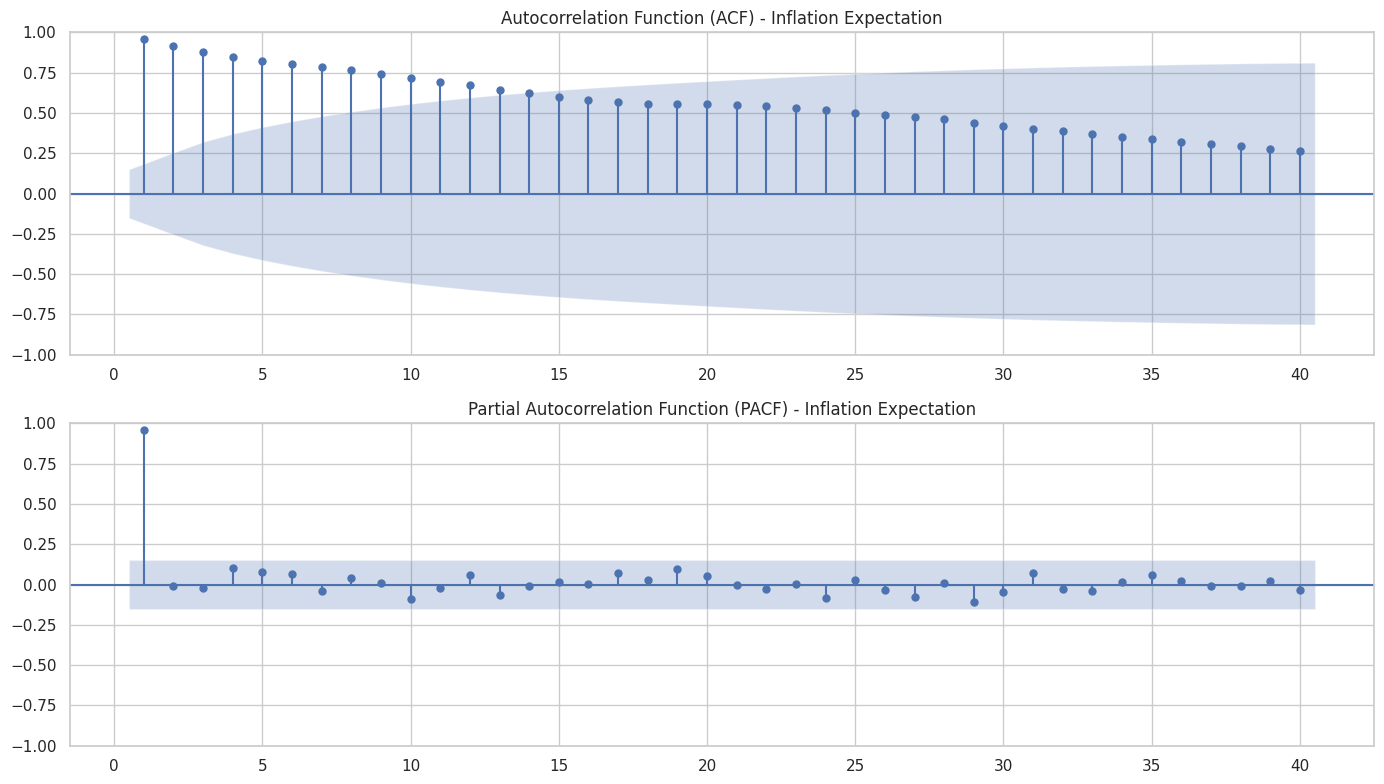

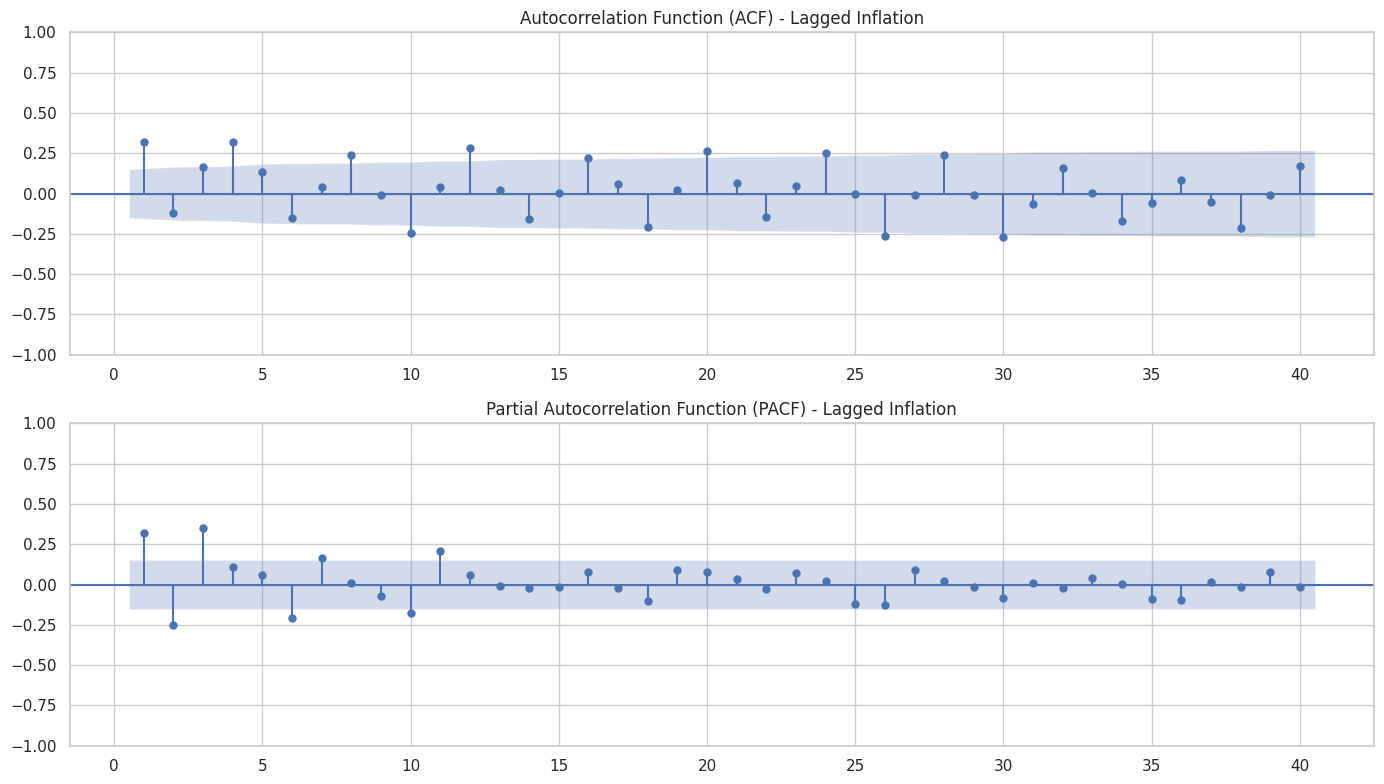

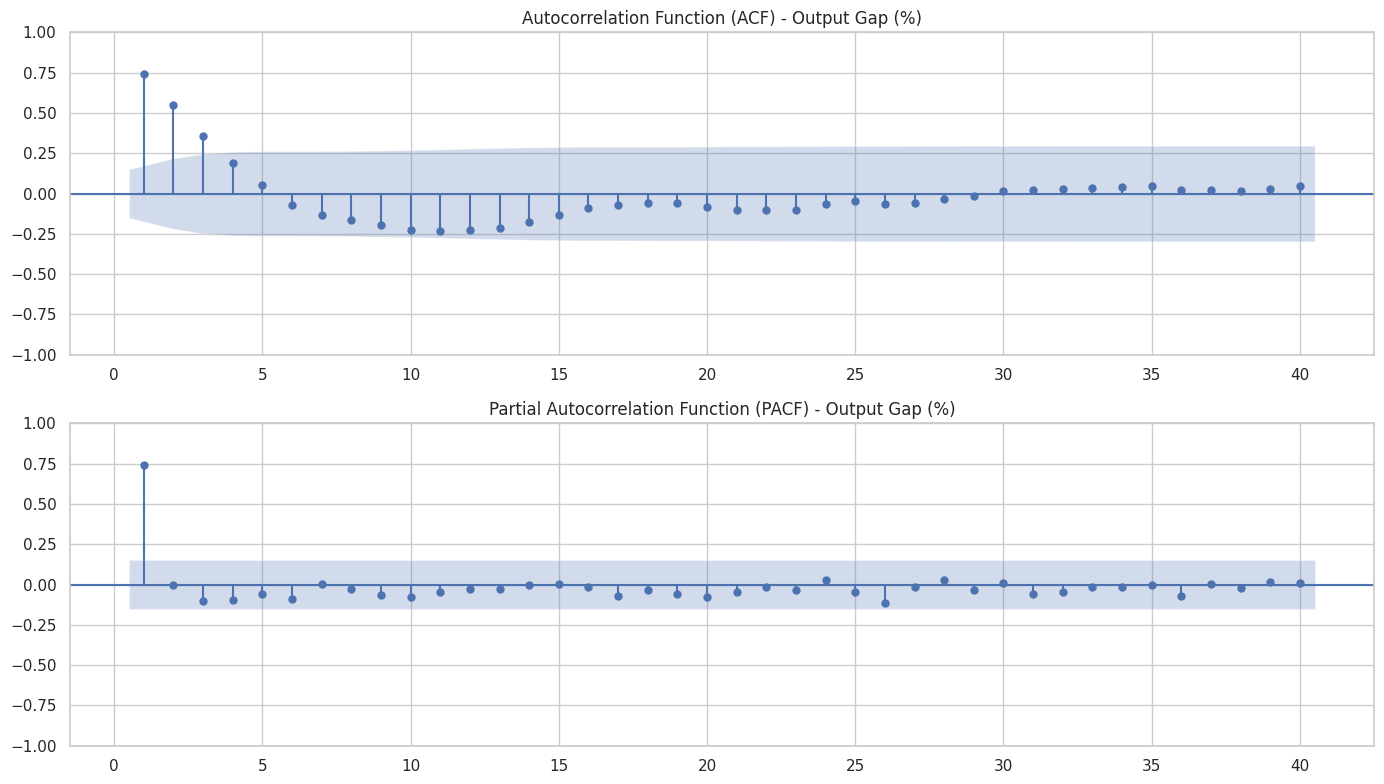

In [20]:
# Set consistent visual theme
sns.set(style="whitegrid", context="notebook")

# List of variables to analyze
variables = ['Inflation Rate', 'Inflation Expectation', 'Lagged Inflation', 'Output Gap (%)']

# Loop through each variable and generate plots
for var in variables:
    series = df[var].dropna()

    # Create subplots for ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=100)

    # Plot ACF
    sm.graphics.tsa.plot_acf(series,
                             lags=40,
                             ax=axes[0],
                             title=f'Autocorrelation Function (ACF) - {var}',
                             zero=False)

    # Plot PACF
    sm.graphics.tsa.plot_pacf(series,
                              lags=40,
                              ax=axes[1],
                              title=f'Partial Autocorrelation Function (PACF) - {var}',
                              zero=False,
                              method='ywm')  

    # Optimize spacing
    plt.tight_layout()
    plt.show()

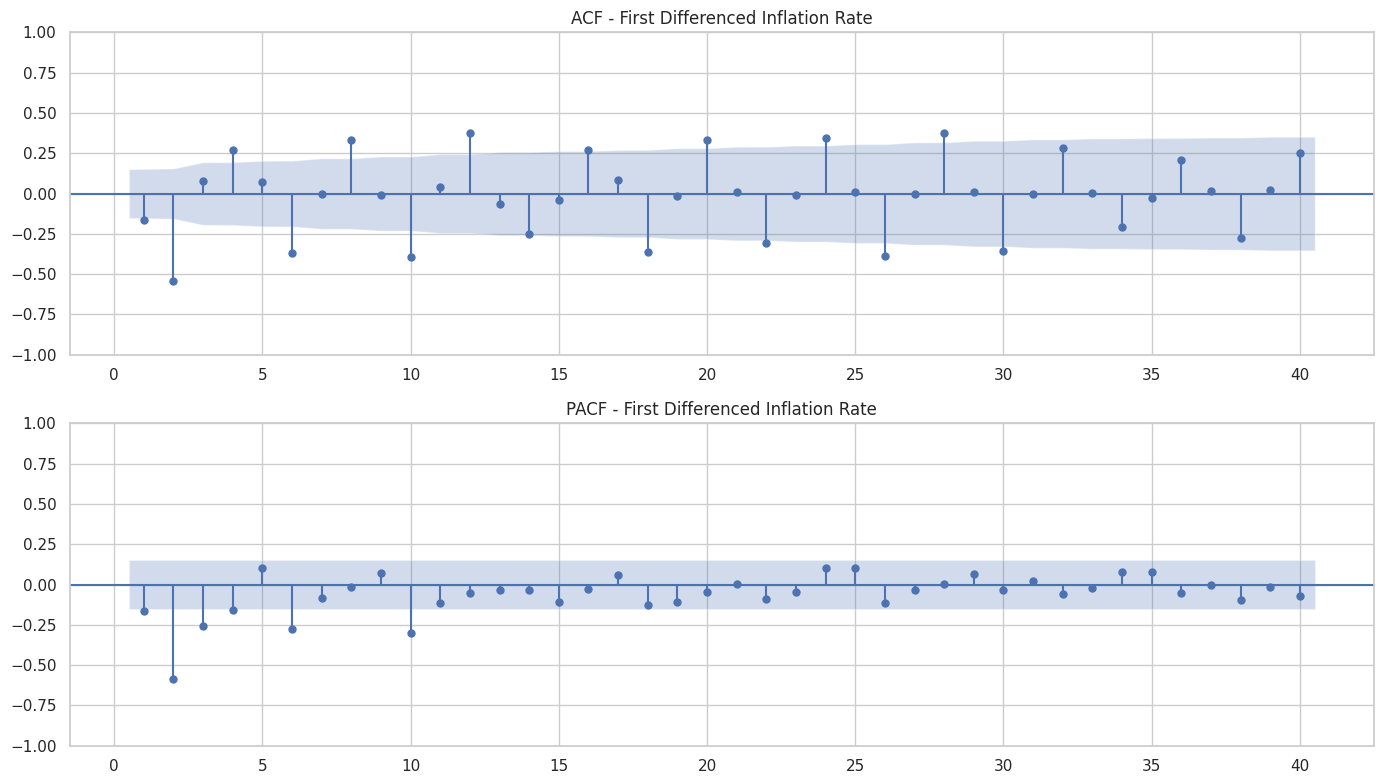

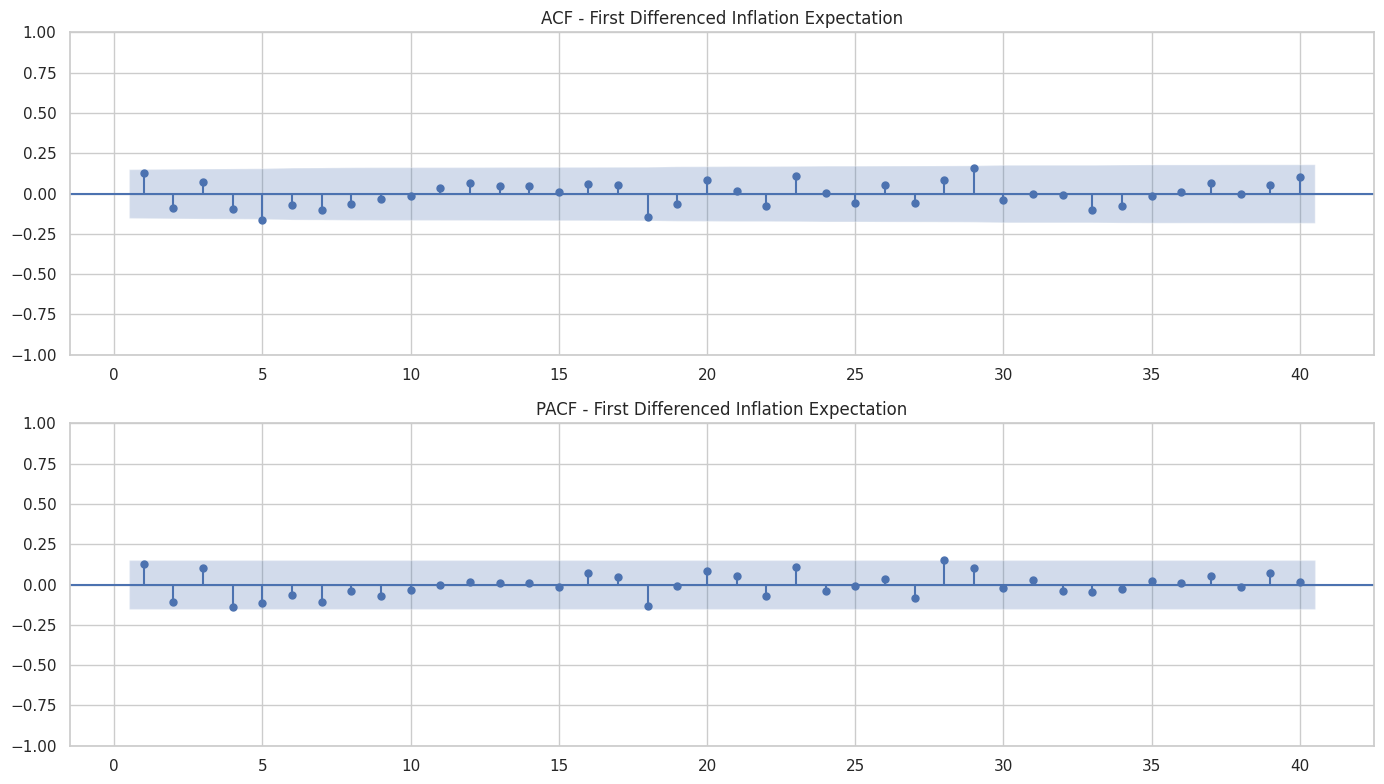

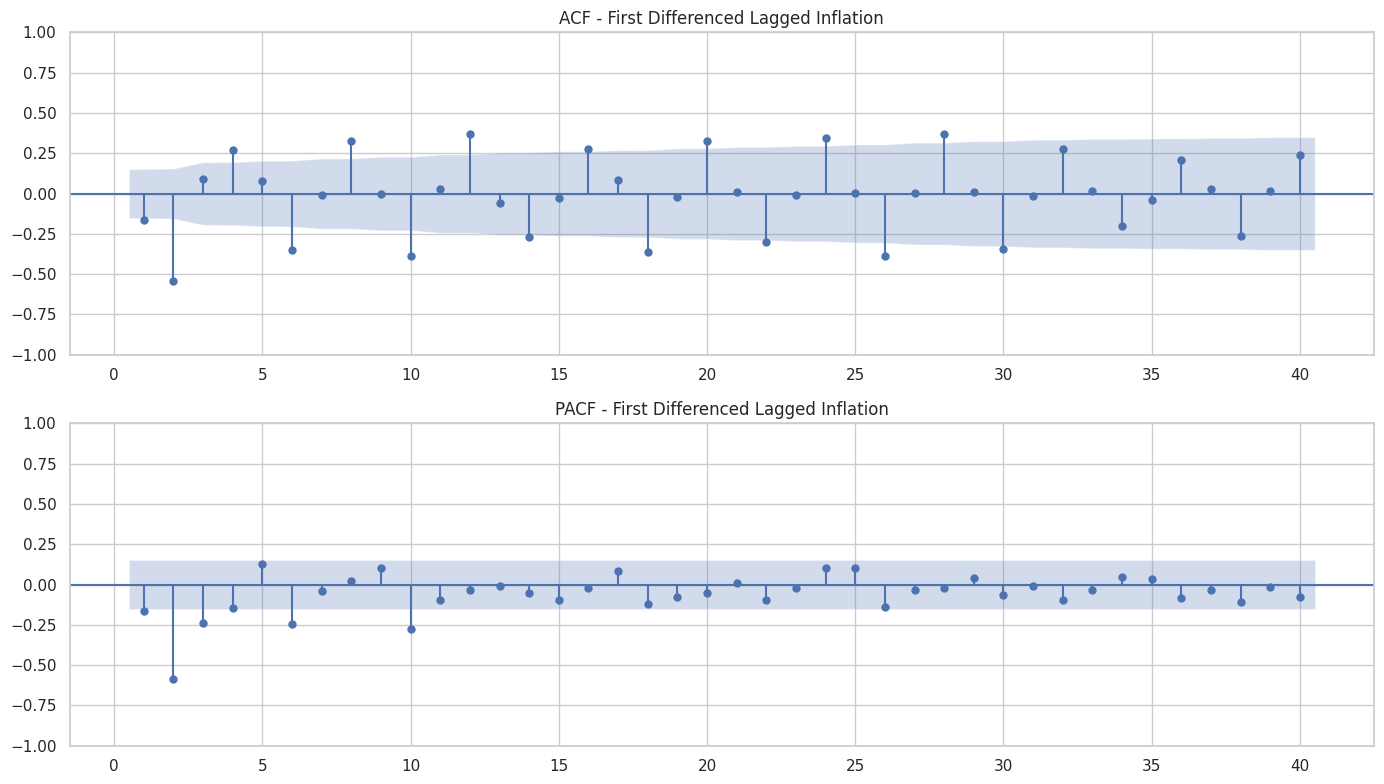

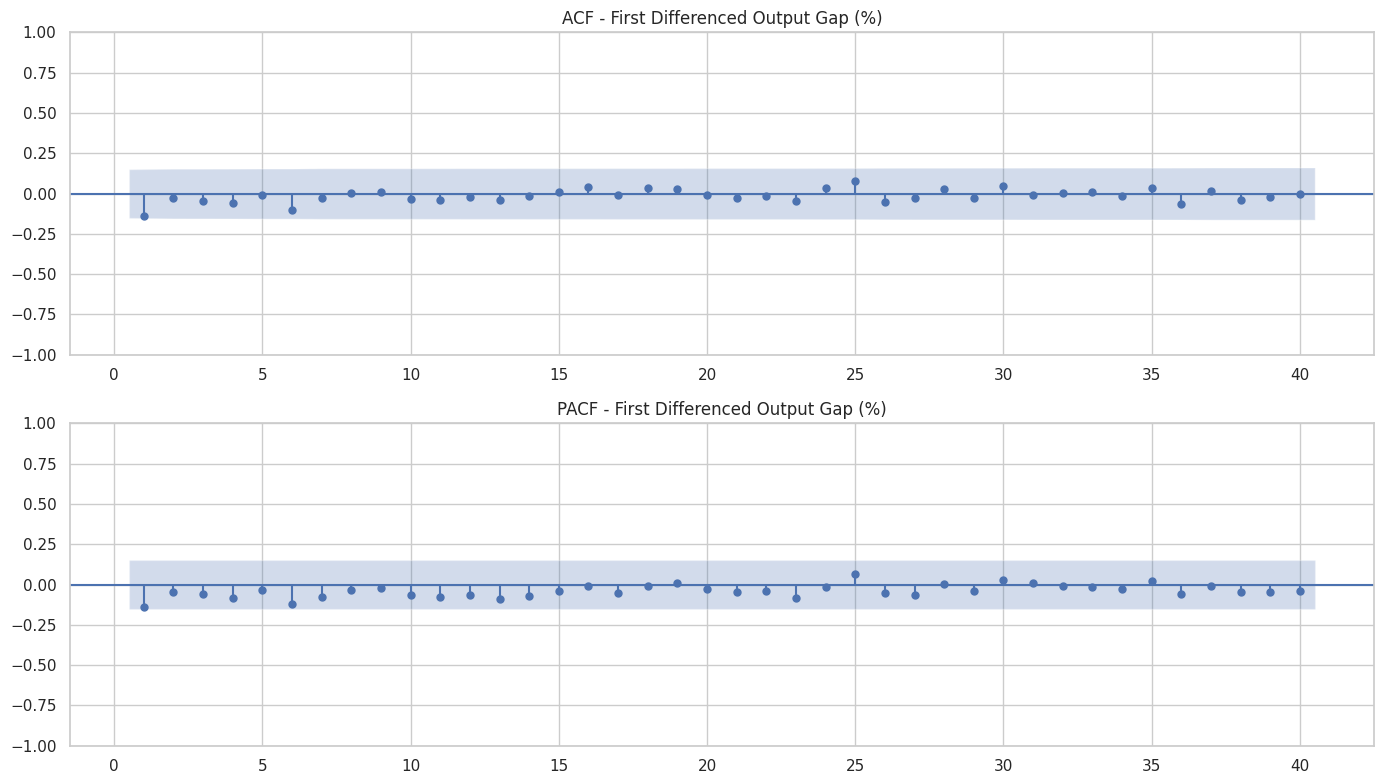

In [21]:
# Set seaborn style for aesthetics
sns.set(style="whitegrid", context="notebook")

# List of variables to process
variables = ['Inflation Rate', 'Inflation Expectation', 'Lagged Inflation', 'Output Gap (%)']

# Loop through each variable and generate ACF & PACF plots
for var in variables:
    # First differencing to ensure stationarity
    diff_series = df[var].diff().dropna()

    # Create subplots for ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=100)

    # ACF
    sm.graphics.tsa.plot_acf(diff_series,
                             lags=40,
                             ax=axes[0],
                             title=f'ACF - First Differenced {var}',
                             zero=False)

    # PACF
    sm.graphics.tsa.plot_pacf(diff_series,
                              lags=40,
                              ax=axes[1],
                              title=f'PACF - First Differenced {var}',
                              zero=False,
                              method='ywm')

    # Adjust layout
    plt.tight_layout()
    plt.show()

## **5.7. Unit Root Tests**

Unit root tests are formal statistical hypothesis tests used to determine if a time series is non-stationary and contains a unit root. The presence of a unit root implies that random shocks have permanent effects on the series, and standard regression techniques applied to such series can lead to spurious results.

- **Augmented Dickey-Fuller (ADF) Test:** A widely used test that examines the null hypothesis that a time series has a unit root against the alternative hypothesis that it is stationary. It accounts for potential autocorrelation in the error term.

- **Phillips-Perron (PP) Test:** Another unit root test that is a modification of the ADF test. It is non-parametric with respect to the form of autocorrelation and heteroskedasticity in the error term.

If a series is found to have a unit root (i.e., is non-stationary), it may become stationary after differencing. A series that is stationary after being differenced once is said to be integrated of order one, denoted as I(1). If it is stationary in its original level form, it is I(0). Unit root tests are crucial for determining the order of integration of time series variables, which is a prerequisite for cointegration analysis and the estimation of Error Correction Models.

In [22]:
# Function to run ADF and PP tests on a single time series
def run_unit_root_tests(series, series_name="Series"):
    results = []

    # ADF Test - Level
    adf_level = adfuller(series.dropna(), autolag='AIC')
    results.append([series_name, 'ADF', 'Level', adf_level[0], adf_level[1]])

    # ADF Test - First Difference
    adf_diff = adfuller(series.dropna().diff().dropna(), autolag='AIC')
    results.append([series_name, 'ADF', '1st Difference', adf_diff[0], adf_diff[1]])

    # Phillips-Perron Test - Level
    pp_level = PhillipsPerron(series.dropna())
    results.append([series_name, 'PP', 'Level', pp_level.stat, pp_level.pvalue])

    # Phillips-Perron Test - First Difference
    pp_diff = PhillipsPerron(series.dropna().diff().dropna())
    results.append([series_name, 'PP', '1st Difference', pp_diff.stat, pp_diff.pvalue])

    return results

# Run unit root tests for all relevant variables
all_results = []
all_results += run_unit_root_tests(df['Inflation Rate'], 'Inflation Rate')
all_results += run_unit_root_tests(df['Lagged Inflation'], 'Lagged Inflation')
all_results += run_unit_root_tests(df['Inflation Expectation'], 'Inflation Expectation')
all_results += run_unit_root_tests(df['Output Gap (%)'], 'Output Gap (%)')

# Convert results to a DataFrame
unit_root_df = pd.DataFrame(all_results, columns=[
    'Variable', 'Test', 'Transformation', 'Test Statistic', 'p-value'
])

# Styled output for better readability
styled_table = (
    unit_root_df.round(4)
    .style.set_caption("Unit Root Tests (ADF & PP) for All Model Variables")
    .format(precision=4)
    .background_gradient(cmap='coolwarm', subset=['p-value'])
    .hide(axis='index')
)

display(styled_table)

Variable,Test,Transformation,Test Statistic,p-value
Inflation Rate,ADF,Level,-2.7597,0.0643
Inflation Rate,ADF,1st Difference,-6.4295,0.0000
Inflation Rate,PP,Level,-9.6281,0.0000
Inflation Rate,PP,1st Difference,-28.1663,0.0000
Lagged Inflation,ADF,Level,-2.8887,0.0467
Lagged Inflation,ADF,1st Difference,-6.3696,0.0000
Lagged Inflation,PP,Level,-9.5256,0.0000
Lagged Inflation,PP,1st Difference,-27.1357,0.0000
Inflation Expectation,ADF,Level,-2.0939,0.2470
Inflation Expectation,ADF,1st Difference,-7.3392,0.0000


In [23]:
# Choosing of Variables
y = df['Inflation Rate']
X = df[['Lagged Inflation', 'Inflation Expectation', 'Output Gap (%)']]
X = sm.add_constant(X)

# OLS Model
ols_model = sm.OLS(y, X).fit()
(print(ols_model.summary()))

                            OLS Regression Results                            
Dep. Variable:         Inflation Rate   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     10.06
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           4.02e-06
Time:                        12:50:36   Log-Likelihood:                -148.86
No. Observations:                 169   AIC:                             305.7
Df Residuals:                     165   BIC:                             318.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.22

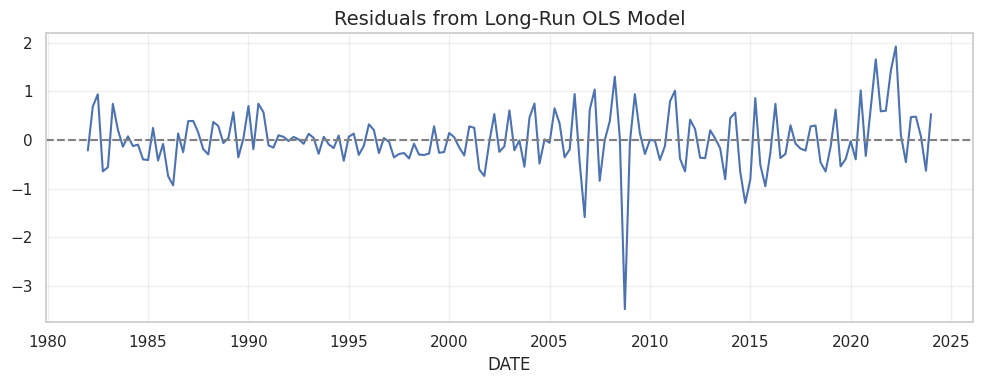

In [24]:
# Remove the residuals
residuals = ols_model.resid

# Graph of Residuals
plt.figure(figsize=(10, 4))
sns.lineplot(x=df.index, y=residuals)
plt.title('Residuals from Long-Run OLS Model', fontsize=14)
plt.axhline(0, color="gray", linestyle="--")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## **5.8. Cointegration Test (Engle-Granger Approach)**

Cointegration is a concept in time series analysis that applies to non-stationary time series. Two or more non-stationary time series are said to be cointegrated if a linear combination of them is stationary. The existence of cointegration implies that these series have a long-term, stable relationship and do not drift arbitrarily far apart over time, despite being non-stationary individually.

The Engle-Granger two-step approach is one method for testing for cointegration between two or more time series. The steps are as follows:

1.  **Estimate the Potential Long-Run Relationship:** Perform an Ordinary Least Squares (OLS) regression of one non-stationary variable on the other non-stationary variables. The coefficients from this regression represent the estimated long-term relationship between the variables.

2.  **Test the Stationarity of the Residuals:** Calculate the residuals from the OLS regression performed in the first step. These residuals represent the deviations from the estimated long-run equilibrium. Apply a unit root test (like the ADF test) to these residuals. If the residuals are found to be stationary (i.e., the unit root hypothesis is rejected for the residuals), then the original non-stationary series are considered to be cointegrated.

The p-value of the unit root test on the residuals is interpreted against specific critical values for cointegration tests, which are different from those used for standard unit root tests on a single series. A significant p-value (typically less than 0.05 or 0.01) provides evidence of cointegration.

In [25]:
# Unit root test on residuals from cointegration regression (Engle-Granger)
adf_stat, p_value, _, _, crit_vals, _ = adfuller(residuals, autolag="AIC")

# Display the results
print('Engle-Granger Cointegration Test (ADF on Residuals)')
print(f'Test Statistic : {adf_stat:.4f}')
print(f'p-value        : {p_value:.4f}')
print('Critical Values:')
for key, val in crit_vals.items():
    print(f'   {key}: {val:.4f}')

Engle-Granger Cointegration Test (ADF on Residuals)
Test Statistic : -4.4091
p-value        : 0.0003
Critical Values:
   1%: -3.4722
   5%: -2.8799
   10%: -2.5766


## **5.9. Econometric Modelling: Error Correction Model (ECM)**

When time series variables are non-stationary but cointegrated, an Error Correction Model (ECM) is an appropriate framework for modeling their relationship. The ECM captures both the short-term dynamics and the adjustment process towards the long-term equilibrium. It is based on the idea that deviations from the long-run relationship in one period influence the short-run changes in the variables in the next period.

The general form of a single-equation ECM is:

$ \Delta y_t = \text{Short-Run Dynamics} + \alpha \cdot \text{ECM Term}_{t-1} + \epsilon_t $

Specifically, for variables $ y_t $ and $ x_t $ that are cointegrated with a long-run relationship $ y_t = \beta_0 + \beta_1 x_t + u_t $, the ECM can be written as:

$ \Delta y_t = \gamma_0 + \gamma_1 \Delta y_{t-1} + \delta_0 \Delta x_t + \delta_1 \Delta x_{t-1} + \alpha u_{t-1} + \epsilon_t $

or, using the residuals from the long-run OLS ($ u_{t-1} = y_{t-1} - \hat{\beta}_0 - \hat{\beta}_1 x_{t-1} $):

$ \Delta y_t = \gamma_0 + \gamma_1 \Delta y_{t-1} + \delta_0 \Delta x_t + \delta_1 \Delta x_{t-1} + \alpha (y_{t-1} - \hat{\beta}_0 - \hat{\beta}_1 x_{t-1}) + \epsilon_t $

- $ \Delta $ represents the first difference operator, capturing short-run changes.

- The terms with $ \Delta y $ and $ \Delta x $ represent the short-run dynamics, showing how current changes are influenced by past changes in the variables.

- The term $ (y_{t-1} - \hat{\beta}_0 - \hat{\beta}_1 x_{t-1}) $ is the **Error Correction Term (ECM Term)**. It represents the lagged deviation from the estimated long-run equilibrium.

- The coefficient $ \alpha $ is the **error correction coefficient**. It measures the speed at which $ y_t $ adjusts to restore the long-run equilibrium after a deviation. For cointegration to be meaningful and for the model to converge to the long-run relationship, $ \alpha $ is expected to be negative and statistically significant. A larger absolute value of $ \alpha $ implies faster adjustment.

In the context of the Modern Phillips Curve, the ECM would typically model the change in inflation as a function of lagged changes in inflation, changes in variables like the output gap and inflation expectations, and the lagged error correction term derived from the long-run Phillips Curve relationship.

In [26]:
# Calculate first differences (short-run changes)
df["D_Inflation"] = df["Inflation Rate"].diff()
df["D_Lagged_Inflation"] = df["Lagged Inflation"].diff()
df["D_Infl_Expectation"] = df["Inflation Expectation"].diff()
df["D_Output_Gap"] = df["Output Gap (%)"].diff()

# Include lagged residuals from the cointegration regression
df["ECM_Residual_Lagged"] = residuals.shift(1)

# Construct the ECM dataset, dropping initial NaN values
ecm_df = df[[
    "D_Inflation", "D_Lagged_Inflation", "D_Infl_Expectation",
    "D_Output_Gap", "ECM_Residual_Lagged"
]].dropna()

# Define dependent and independent variables
y_ecm = ecm_df["D_Inflation"]
X_ecm = ecm_df[[
    "D_Lagged_Inflation", "D_Infl_Expectation", 
    "D_Output_Gap", "ECM_Residual_Lagged"
]]
X_ecm = sm.add_constant(X_ecm)  # Add intercept term

# Estimate the ECM model
ecm_model = sm.OLS(y_ecm, X_ecm).fit()
print(ecm_model.summary())

                            OLS Regression Results                            
Dep. Variable:            D_Inflation   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     40.14
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           2.23e-23
Time:                        12:50:38   Log-Likelihood:                -130.63
No. Observations:                 168   AIC:                             271.3
Df Residuals:                     163   BIC:                             286.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0228    

In [27]:
# Dataset appropriate for the Granger test
granger_df = df[['Inflation Rate', 'Lagged Inflation', 'Inflation Expectation', 'Output Gap (%)']].dropna()

# Maximum Lag (for example 4)
max_lag = 4

# Granger test for Independent Variables
variables = ['Lagged Inflation', 'Inflation Expectation', 'Output Gap (%)']

for var in variables:
    print(f"\nGranger Causality Test: {var} → Inflation Rate")
    grangercausalitytests(granger_df[['Inflation Rate', var]], maxlag=max_lag, verbose=True)


Granger Causality Test: Lagged Inflation → Inflation Rate

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0763 , p=0.0011  , df_denom=165, df_num=1
ssr based chi2 test:   chi2=11.2777 , p=0.0008  , df=1
likelihood ratio test: chi2=10.9153 , p=0.0010  , df=1
parameter F test:         F=11.0763 , p=0.0011  , df_denom=165, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2941 , p=0.0000  , df_denom=163, df_num=2
ssr based chi2 test:   chi2=25.1916 , p=0.0000  , df=2
likelihood ratio test: chi2=23.4633 , p=0.0000  , df=2
parameter F test:         F=19.1997 , p=0.0000  , df_denom=163, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7389  , p=0.5303  , df_denom=161, df_num=3
ssr based chi2 test:   chi2=2.2855  , p=0.5153  , df=3
likelihood ratio test: chi2=2.2699  , p=0.5183  , df=3
parameter F test:         F=13.0433 , p=0.0000  , df_denom=161, df_num=3

Granger Causality
number of lags (

## **5.10. Model Diagnostic Tests**

After estimating an econometric model like the Error Correction Model (ECM), it is crucial to perform diagnostic tests on the model's residuals and the structure of the model itself. These tests assess whether the assumptions underlying the estimation method are met and evaluate the overall reliability and validity of the model. Violations of these assumptions can lead to biased or inefficient estimates, incorrect standard errors, and unreliable statistical inferences.

Common diagnostic tests for time series regression models include:

- **Ljung-Box Test (Test for Autocorrelation):** This test checks if the residuals are serially correlated (i.e., if there is autocorrelation in the error term). The null hypothesis is that there is no autocorrelation up to a specified number of lags. Significant autocorrelation in the residuals indicates that the model has not fully captured the dynamic structure of the data, and there might be missing variables or an incorrect specification of the lag structure.

- **Jarque-Bera Test (Test for Normality):** This test assesses whether the residuals are normally distributed. The null hypothesis is that the residuals are from a normal distribution. Non-normal residuals, especially in smaller samples, can affect the validity of t-tests and F-tests, although OLS estimators are still the Best Linear Unbiased Estimators (BLUE) if other assumptions hold. Severe non-normality might suggest the presence of outliers or that the chosen model is not the best fit for the data's distribution.

- **Breusch-Pagan Test (Test for Heteroskedasticity):** This test examines whether the variance of the residuals is constant across all levels of the independent variables (homoskedasticity). The null hypothesis is that the residuals are homoskedastic. If the test is significant (indicating heteroskedasticity), the OLS estimates are still consistent and unbiased, but their standard errors are biased, leading to incorrect hypothesis tests and confidence intervals.

- **Variance Inflation Factor (VIF) Analysis (Test for Multicollinearity):** VIF measures how much the variance of the estimated regression coefficient is increased due to multicollinearity (high correlation) among the independent variables. A VIF value of 1 means no correlation. Values greater than 5 or 10 are often considered indicative of significant multicollinearity, which can make it difficult to interpret individual coefficients and can lead to large standard errors and unstable estimates.

Performing these diagnostic tests helps in identifying potential issues with the estimated model and provides guidance on necessary model modifications or the use of alternative estimation techniques (e.g., robust standard errors).

### **5.10.1. Ljung-Box Test (Test for Autocorrelation)**

In [28]:
# Take the residuals
ecm_resid = ecm_model.resid

# Ljung-Box test (lag=10)
lb_test = acorr_ljungbox(ecm_resid, lags=[10], return_df=True)
print("Ljung-Box Test (Lag=10):")
display(lb_test)

Ljung-Box Test (Lag=10):


,lb_stat,lb_pvalue
10,59.096695,5.369877e-09


### **5.10.2. Jarque-Bera Test (Test for Normality):**

In [29]:
jb_stat, jb_pval, _, _ = jarque_bera(ecm_resid)
print(f"Jarque-Bera Test:\nStatistic = {jb_stat:.4f}, p-value = {jb_pval:.4f}")

Jarque-Bera Test:
Statistic = 96.0325, p-value = 0.0000


### **5.10.3. Breusch-Pagan Test (Test for Heteroskedasticity)**

In [30]:
# Define dependent and independent variables (again, for clarity)
y = ecm_df['D_Inflation']
X = sm.add_constant(ecm_df[['D_Lagged_Inflation', 'D_Infl_Expectation', 'D_Output_Gap', 'ECM_Residual_Lagged']])

# Run Breusch-Pagan Test for heteroskedasticity
bp_test = het_breuschpagan(ecm_model.resid, X)

# Extract results
lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test

# Display results
print("Breusch-Pagan Test for Heteroskedasticity")
print(f"LM Statistic       = {lm_stat:.4f}")
print(f"LM Test p-value    = {lm_pvalue:.4f}")
print(f"F-statistic        = {f_stat:.4f}")
print(f"F-statistic p-value= {f_pvalue:.4f}")

Breusch-Pagan Test for Heteroskedasticity
LM Statistic       = 15.5477
LM Test p-value    = 0.0037
F-statistic        = 4.1559
F-statistic p-value= 0.0031


### **5.10.4. Variance Inflation Factor (VIF) Analysis (Test for Multicollinearity)**

In [31]:
# Variance Inflation Factor (VIF) Test for Multicollinearity

from pandas.api.types import is_numeric_dtype

# Define independent variables including constant
X_vif = add_constant(ecm_df[['D_Lagged_Inflation', 'D_Infl_Expectation', 'D_Output_Gap', 'ECM_Residual_Lagged']])

# Compute VIF values
vif_values = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Create DataFrame and ensure VIF column is numeric
vif_df = pd.DataFrame({
    'Variable': X_vif.columns,
    'VIF': vif_values
})

# Make sure formatting applies only to numeric data
vif_df['VIF'] = pd.to_numeric(vif_df['VIF'], errors='coerce')

# Styled VIF table
vif_styled = vif_df.style.set_caption("Variance Inflation Factor (VIF) for Explanatory Variables") \
                         .format({'VIF': "{:.2f}"}) \
                         .bar(subset=["VIF"], color="lightblue") \
                         .hide(axis="index")

display(vif_styled)

Variable,VIF
const,1.02
D_Lagged_Inflation,2.69
D_Infl_Expectation,1.14
D_Output_Gap,1.09
ECM_Residual_Lagged,2.63


## **5.11. Re-estimation of the ECM Model with Robust Standard Errors**

When diagnostic tests reveal the presence of heteroskedasticity (non-constant variance of residuals), the standard errors computed by the standard OLS method are no longer reliable. This means that the t-statistics, p-values, and confidence intervals derived from these standard errors may lead to incorrect conclusions about the statistical significance of the model coefficients.

While OLS estimates remain unbiased and consistent even in the presence of heteroskedasticity, inference based on them is compromised. To address this, **Heteroskedasticity-Consistent (HC) Robust Standard Errors** are used. These standard errors are calculated in a way that accounts for the varying variance of the residuals, providing valid standard errors, t-statistics, and p-values for hypothesis testing.

Various methods for calculating HC standard errors exist (e.g., HC0, HC1, HC3). HC0, also known as White standard errors, is a common approach that provides consistent estimates of the standard errors under heteroskedasticity. Using robust standard errors allows for reliable statistical inference about the estimated coefficients even when the assumption of homoskedasticity is violated. The estimated coefficients themselves do not change when using robust standard errors; only their standard errors and the associated test statistics and p-values are affected.

In [32]:
ecm_model_robust = sm.OLS(y_ecm, X_ecm).fit(cov_type='HC0')  # White standard errors
print(ecm_model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:            D_Inflation   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     31.45
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           2.07e-19
Time:                        12:50:39   Log-Likelihood:                -130.63
No. Observations:                 168   AIC:                             271.3
Df Residuals:                     163   BIC:                             286.9
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0228    

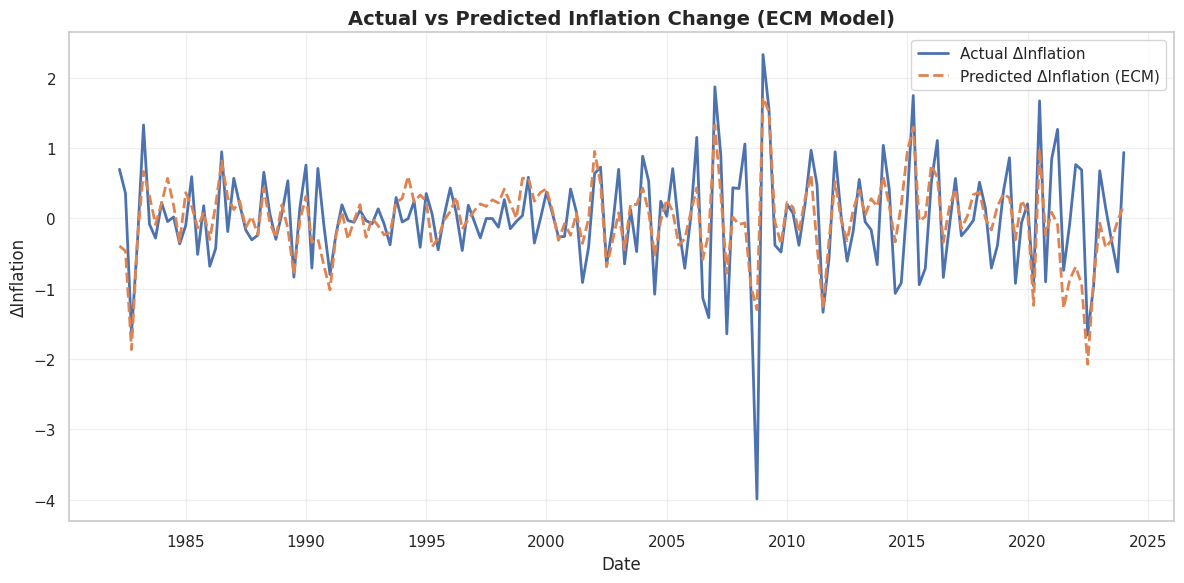

In [33]:
# Estimated ΔInflation values
ecm_df['Predicted_D_Inflation'] = ecm_model_robust.fittedvalues

plt.figure(figsize=(12, 6))
sns.lineplot(x=ecm_df.index, y=ecm_df['D_Inflation'], label='Actual ΔInflation', linewidth=2)
sns.lineplot(x=ecm_df.index, y=ecm_df['Predicted_D_Inflation'], label='Predicted ΔInflation (ECM)', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Inflation Change (ECM Model)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('ΔInflation')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

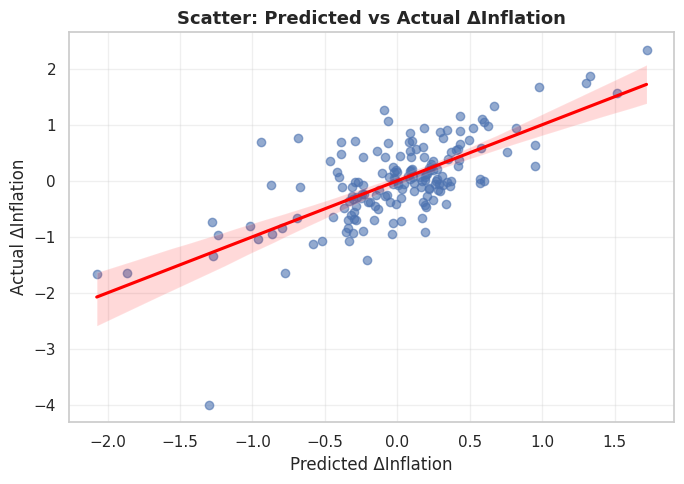

In [34]:
plt.figure(figsize=(7, 5))
sns.regplot(x=ecm_df['Predicted_D_Inflation'], y=ecm_df['D_Inflation'],
            line_kws={"color": "red"}, scatter_kws={"alpha": 0.6})
plt.title('Scatter: Predicted vs Actual ΔInflation', fontsize=13, fontweight='bold')
plt.xlabel('Predicted ΔInflation')
plt.ylabel('Actual ΔInflation')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## **5.12. Evaluating Model Performance**

Evaluating the performance of a time series model is crucial for understanding how well it fits the data and its potential for forecasting. This involves comparing the actual values of the dependent variable with the values predicted by the estimated model. Several metrics are commonly used to quantify model performance, particularly in assessing the accuracy of predictions:

- **Root Mean Squared Error (RMSE):** This metric measures the square root of the average of the squared differences between actual and predicted values. It gives a relatively high weight to large errors, making it sensitive to outliers. RMSE is in the same units as the dependent variable, which aids in interpretation.

- **Mean Absolute Error (MAE):** This metric calculates the average of the absolute differences between actual and predicted values. It provides a straightforward measure of the average magnitude of errors, with all errors weighted equally. Like RMSE, MAE is in the same units as the dependent variable.

- **Mean Absolute Percentage Error (MAPE):** This metric expresses the average of the absolute percentage errors. It is calculated as the average of the absolute difference between actual and predicted values, divided by the actual values, and then multiplied by 100. MAPE is useful for comparing the accuracy of models across different datasets or variables with different scales, as it is a percentage measure. However, it can be problematic or undefined when actual values are zero or very close to zero.

Visualizations such as scatter plots comparing actual vs. predicted values or time series plots showing both series are also valuable for qualitatively assessing model fit and identifying patterns in the errors. These evaluations help determine if the model adequately captures the dynamics of the dependent variable.

In [35]:
y_true = ecm_df['D_Inflation']
y_pred = ecm_df['Predicted_D_Inflation']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Forecast Performance:")
print(f"RMSE  = {rmse:.4f}")
print(f"MAE   = {mae:.4f}")
print(f"MAPE  = {mape:.2f}%")


Forecast Performance:
RMSE  = 0.5266
MAE   = 0.3880
MAPE  = 461.33%


## **5.13. Conclusion and Discussion**

This final section summarizes the key findings of the time series analysis of the Modern Phillips Curve and discusses their implications. It brings together the results from data preprocessing, EDA, unit root tests, cointegration analysis, ECM estimation, and model diagnostics. The discussion focuses on interpreting the estimated relationships (both long-term and short-term dynamics), the significance of the error correction mechanism, and the insights gained regarding the factors driving inflation. Potential limitations of the analysis, issues identified by diagnostic tests, and avenues for future research or model improvements are also typically addressed. The conclusion aims to provide a concise synthesis of the research process and its contribution to understanding the dynamics of inflation within the framework of the Modern Phillips Curve.

# **6. References**

This section provides a list of key references relevant to the concepts and methods used in this notebook for the empirical analysis of the Modern Phillips Curve.

*   **Blanchard, O. (2016).** *Macroeconomics* (7th ed.). Pearson. (Provides a comprehensive overview of macroeconomic models, including the Phillips Curve).
*   **Engle, R. F., & Granger, C. W. J. (1987).** Co-integration and error correction: Representation, estimation, and testing. *Econometrica*, 55(2), 251-276. (Foundational paper on cointegration and ECM).
*   **Hamilton, J. D. (1994).** *Time Series Analysis*. Princeton University Press. (A standard graduate-level textbook covering time series models, stationarity, unit roots, and cointegration).
*   **Phillips, A. W. (1958).** The relation between unemployment and the rate of change of money wage rates in the United Kingdom, 1861-1957. *Economica*, 25(100), 283-299. (Original paper introducing the Phillips Curve concept).
*   **Stock, J. H., & Watson, M. W. (2007).** *Introduction to Econometrics* (2nd ed., Updated ed.). Addison-Wesley. (Covers econometric methods for time series data, including unit root tests and cointegration).
*   **FRED (Federal Reserve Economic Data).** Federal Reserve Bank of St. Louis. (Source for the macroeconomic data used in this analysis). Available at: [https://fred.stlouisfed.org/](https://fred.stlouisfed.org/)